In [1]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 
import random
import ast
import html
import re
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm
#np.set_printoptions(threshold=np.inf) #set to print full output
import numpy as np
random.seed(42)
#os.chdir('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline')
import sys
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModel  # Import AutoTokenizer and AutoModel
import nltk
nltk.download('stopwords')

#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

2025-03-14 16:52:26.389593: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 16:52:27.338155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 16:52:27.342727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 16:52:33.909911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ll16598/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:


model_name='all-MiniLM-L6-v2'
sentence_model = SentenceTransformer(model_name)  # or any SBERT model from Hugging Face
#THIS IS A MULTILINGUAL SEMANTIC SIMILARITY MODEL
# Load the model and tokenizer
model_name = 'sentence-transformers/'+model_name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
save_directory = './BERT_models/all-MiniLM-L6-v2'

# Save model and tokenizer\
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./BERT_models/all-MiniLM-L6-v2/tokenizer_config.json',
 './BERT_models/all-MiniLM-L6-v2/special_tokens_map.json',
 './BERT_models/all-MiniLM-L6-v2/vocab.txt',
 './BERT_models/all-MiniLM-L6-v2/added_tokens.json',
 './BERT_models/all-MiniLM-L6-v2/tokenizer.json')

In [75]:
import re

# Define the file path
file_path = '/home/ll16598/Documents/POSTDOC/cleaned_data/cleaned_SER2_monologs.txt'

# Open and read the file as a block of text
with open(file_path, 'r', encoding='utf-8') as file:
    data_monologs = file.read()

# Regular expression to match classification headers like %#CLASSIFICATION#SOME TEXT#
pattern = r'%#([^#]+)#'

# Split the text based on the pattern to separate sections
sections = re.split(pattern, data_monologs)

# Lists to store classifications and corresponding text sections
classification = []
text_blocks = []

# Iterate through the split sections
for i in range(1, len(sections), 2):
    current_section = sections[i].strip()  # Get the section between the hashtags
    corresponding_text = sections[i + 1].strip() if i + 1 < len(sections) else ""  # Get the following text
    
    # Append the classification and corresponding text block
    classification.append(current_section)
    
    # Add corresponding text blocks if they meet the length condition
   # if len(corresponding_text) > 20:
    corresponding_text = re.sub(r'^[^#]*#', '', corresponding_text).strip()
    text_blocks.append(corresponding_text)
# Now, classification contains section identifiers, and text_blocks contains corresponding text

# Example output to check the first few entries
for c, t in zip(classification, text_blocks):
    print(f"Classification: {c}")
    print(f"Text Block: {t[:100]}...")  # Print only the first 100 characters of the text for brevity
    print("-" * 50)


Classification: SER202.s1.Monolog
Text Block: uh so this feels a little strange to be talking into this, but um I’m feeling pretty uh that I will ...
--------------------------------------------------
Classification: SER202.s2.Monolog
Text Block: [Noises] All right, so um I’m moderately bummed that Selena just left the room.  Uh I enjoy talking ...
--------------------------------------------------
Classification: SER202.s3.Monolog
Text Block: [Noises] Um all right, so not feeling out of the ordinary at all right now um so a little tired.  I ...
--------------------------------------------------
Classification: SER204.s1.monolog
Text Block: [Noises] This is by far one of the strangest highs I’ve ever had.  Um [deep breath] it feels like uh...
--------------------------------------------------
Classification: SER204.s2.monolog
Text Block: [Beeping] [Noises] I need to go.  I need to run.  I need to run.  I need to run now.  I need to go r...
----------------------------------------------

Note that 229 is missing as no text

In [88]:
import ast
import html
import re

import re
import pandas as pd

def preprocess_text(text):
    # Check if the text is NaN (null), and handle it
    if pd.isna(text):
        return ''
    text=text.lower()
    # (1) DO NOT convert to lowercase -> line removed/omitted
    
    # (2) Remove digits (optional — keep or remove depending on your needs)
    # If you do NOT want to remove digits, comment this line out:
    # text = re.sub(r'\d+', '', text)
    
    # (3) Remove all text inside square brackets AND parentheses (including the brackets themselves)
    #    - If there could be nested parentheses/brackets, this regex won't handle nesting properly.
    #    - For simple cases, this works fine.
    text = re.sub(r'\[.*?\]', '', text)  # remove square-bracketed content
    text = re.sub(r'\(.*?\)', '', text)  # remove parenthesized content

    # (4) Replace newline characters with a space
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # (5) Replace multiple dots ("..") with a single space
    #     (Adjust or remove this if you want to preserve repeated dots.)
    text = re.sub(r'\.\.', ' ', text)
    
    # (6) Remove 'rr' when it occurs at the start of a word (based on your original code)
    text = re.sub(r'\brr\w*', '', text)
    
    # (7) PRESERVE punctuation -> so we remove the old line that stripped everything except periods:
    #     text = re.sub(r'[^\w\s\.]', '', text)
    #     ^ Commented out/removed because you want to keep punctuation.

    # (8) Ensure single spacing between words and strip leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+([.,])', r'\1', text)
    # Replace exactly two consecutive periods ".." with a single period "."
    text = re.sub(r'(?<!\.)\.\.(?!\.)', '.', text)
    text = re.sub(r'[-\\—]', ' ', text)
    text = re.sub(r'[-\\—–]', ' ', text)
    text=re.sub(r'\s+', ' ', text)
    return text
# Example usage
#preprocessed_data = [preprocess_text(str(narrative)) for narrative in text_blocks]


In [89]:
df=pd.DataFrame({'texts':text_blocks,
                 'classification':classification})
#df = df.drop(index=51)
df['processed_text']=df['texts'].apply(preprocess_text)
# If you want to reset the index after dropping, you can do this:
df = df.reset_index(drop=True)

In [90]:
df.columns

Index(['texts', 'classification', 'processed_text'], dtype='object')

In [91]:
list(df.classification)

['SER202.s1.Monolog',
 'SER202.s2.Monolog',
 'SER202.s3.Monolog',
 'SER204.s1.monolog',
 'SER204.s2.monolog',
 'SER204.s3.Monolog',
 'SER208.s1.monolog',
 'SER208.s2',
 'SER208.s3.monolog',
 'SER209.s1.monolog',
 'SER209.s2.monolog',
 'SER209.s3.monolog',
 'SER216.s1.monolog',
 'SER216.s2.monolog.',
 'SER216.s3.Monolog',
 'SER218.s1.monolog',
 'SER218.s2.monolog',
 'SER218.s3.monolog',
 '1293_SER220.s1.monolog',
 '1293_SER220.s2.monolog',
 '1293_SER220.s3.Monolog',
 'SER221.s1.monolog',
 'SER221.s2.monolog',
 'SER221.s3.monolog',
 'SER223.s1.Monolog',
 'SER223.s2.monolog',
 'SER223.s3.Monolog',
 '1293_SER225.s1.monolog',
 '1293_SER225.s2.monolog',
 '1293_SER225.s3.Monolog',
 'SER226.s1.monolog',
 'SER226.s2.Monolog',
 'SER226.s3.Monolog',
 '1293_SER228.s1.Monolog',
 '1293_SER228.s2.Monolog',
 '1293_SER228.s3.Monolog',
 'SER233.s1.Monolog',
 'SER233.s2.monolog',
 'SER233.s3.monolog',
 'SER234.s1.monolog',
 'SER234.s2.monolog',
 'SER234.s3.monolog',
 '1293_SER235.s1.monolog',
 '1293_SER2

In [92]:
df_drug=pd.read_csv('/home/ll16598/Documents/POSTDOC/Context-DATM/atom_assigned_dfs/df_monolog_244.csv')

In [93]:
threshold=244
# infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_cluster_dicts_{window}_{embedding_step}/cluster_dictionary_{save_thresh}','rb')
# cluster_dictionary=pickle.load(infile)
# infile.close()

user='luke'
if user=='luke':
    working_dir='/home/ll16598/Documents/POSTDOC/'
    dir_atom_dfs='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/atom_assigned_dfs'
df['Drug']=df_drug['Drug']


In [95]:
df.to_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')


In [96]:
#stop_words = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize
def get_sentence_embeddings(sentences):
    embeddings=[]
#    token_embeddings=[]
    for sentence in sentences:
        sentence_embedding = sentence_model.encode(sentence)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)#, token_embeddings

def clean_tokens(tokens):    
    # Filter out stopwords and invalid tokens
    clean_list = [
        token for token in tokens
        if token.isalpha()  # Keep only alphabetic tokens
        and token.lower() not in stop_words  # Remove stopwords
        and not token.startswith("##")  # Remove subword tokens like "##z"
    ]
    return clean_list

def split_text_into_sentences(text, min_tokens=1):
    pattern = r'[^.]+\.'
    sentences = re.findall(pattern, text)
    sentences = [s.strip() for s in sentences if len(s.strip().split()) >= min_tokens]
    return sentences


In [97]:
pattern = r'SER(\d+)\.(s\d+)'

# Apply the regex to extract 'Participant' and 'Session' from the 'classification' column
df['Participant'] = df['classification'].apply(lambda x: re.search(pattern, x, re.IGNORECASE).group(1) if re.search(pattern, x, re.IGNORECASE) else None)
df['Session'] = df['classification'].apply(lambda x: re.search(pattern, x, re.IGNORECASE).group(2) if re.search(pattern, x, re.IGNORECASE) else None)


In [98]:
def remove_t(text):
    text2= re.sub(r"\s't\s", " ", text)
    if len(text2)<len(text):
        print('oh')
    return text2

In [119]:
df_list=[]
data_name_list=[]
df_list.append(df)
data_name_list.append('SER_monologs')
preprocessed_df_dir='/home/ll16598/Documents/POSTDOC/preprocessed_dfs'
for filename in os.listdir(preprocessed_df_dir):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Read the CSV file into a dataframe
        file_path = os.path.join(preprocessed_df_dir, filename)
        df = pd.read_csv(file_path)
        df['processed_text']=df['processed_text'].apply(remove_t)
        # Append the dataframe and the filename (without directory) to the list
        df_list.append(df)
        print('read', filename[:-4])
        data_name_list.append(filename[:-4])

read SER_IPSP
oh
oh
read SER1
read PEM_df
read MASM
read cleaned_DEI


In [120]:
save_df_dir='/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'
dir_array='/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'


In [121]:
model_name='all-MiniLM-L6-v2'
sentence_model = SentenceTransformer(model_name)  # or any SBERT model from Hugging Face
#THIS IS A MULTILINGUAL SEMANTIC SIMILARITY MODEL
# Load the model and tokenizer
model_name = 'sentence-transformers/'+model_name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [122]:
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/vector_assigned_dfs'


In [123]:
def split_text_into_sentences(text, min_tokens=1):
    # Regex pattern to capture sentences ending with ., ?, or ! including ending quotation marks
    pattern = r'[^.!?]+[.!?]"?|[.!?]'
    
    # Extract sentences
    sentences = re.findall(pattern, text)
    
    # Strip whitespace and filter based on token count
    sentences = [s.strip() for s in sentences if len(s.strip().split()) >= min_tokens]
    
    return sentences
def utterance_windows(utts, utt_span=3, utt_step=1):
    spanned_utts=[]
    for i in range(0, len(utts)-utt_span+1, utt_step):
        spanned_utts.append(" ".join(utts[i:i + utt_span]))  # Join each window into a string        
    return spanned_utts
def get_sentence_embeddings(sentences):
    embeddings=[]
#    token_embeddings=[]
    for sentence in sentences:
        sentence_embedding = sentence_model.encode(sentence)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)#, token_embeddings

def process_texts_utterances(df, span=3, step=1, batch_size=16, rm_back=False):
    # Columns to store results
    sentence_embeddings_column = []
    most_similar_atoms_column = []
    sentences_column=[]
    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['processed_text'].iloc[i:i + batch_size]
#         if rm_back:
#             batch_atoms = df['atom_seq'].iloc[i:i + batch_size]


        # Temporary lists to store batch results
        batch_sentence_embeddings = []
        batch_most_similar_atoms = []
        batch_sentences=[]
        # Iterate over texts in the current batch
        for jj, text in enumerate(batch_texts):
            # Step 1: Split text into sentences or windows
#             if rm_back:
#                 sen_topics=batch_atoms.iloc[jj]
            sentences = split_text_into_sentences(text)
            if rm_back:
                sentences = [i for idx, i in enumerate(sentences) if i\
                             not in exclude_tokens]
                removed_sentences=[i for idx, i in enumerate(sentences) if i\
                             in exclude_tokens]
                if len(removed_sentences)>0:
                    print(removed_sentences)
            spanned_sens=utterance_windows(sentences, span, step)
            # Step 2: Get sentence embeddings and most similar atoms
            sentence_embeddings = get_sentence_embeddings(spanned_sens)
            batch_sentence_embeddings.append(sentence_embeddings)
            batch_sentences.append(sentences)
        sentence_embeddings_column.extend(batch_sentence_embeddings)
        sentences_column.extend(batch_sentences)
    df['sentence_embeddings'] = sentence_embeddings_column
    df['sentences'] = sentences_column
    return df

In [124]:
exclude_tokens=[
    "so yeah.",
    "yeah.",
    "so.",
    "so, yeah.",
    "but yeah.",
    "so yeah, yeah.",
    "um yeah.",
    "oh yeah.",
    "yeah, yeah.",
    "so right.",
    "uh, yeah.",
    "right.",
    "and yeah.",
    "” yeah.",
    "um, yeah.",
    "uh huh.",
    "so uh, yeah.",
    "oh, yeah.",
    "but um yeah.",
    "but, yeah.",
    "so oh, yeah.",
    "okay.",
    "alright.",
    "” so, yeah.",
    "um yeah, yeah.",
    "um and yeah.",
    "exactly.",
    "um.",
    "so, um, yeah.",
    "um, but yeah.",
    "he yeah.",
    "yeah?",
    "but, um yeah.",
    "so definitely.",
    "but um, yeah.",
    "yes.",
    "um, so, yeah.",
    "so she yeah.",
    ".",
    "and um yeah.",
    "um, and yeah.",
    "indeed.",
    "no.",
    "yeah, i guess so.",
    "yeah, i guess.",
    "right?",
    "um oh, yeah.",
    "and um, yeah.",
    "um, okay.",
    "sure.",
    "yeah, yeah, definitely.",
    "yeah, yeah.",
    "um yeah, yeah.",
    "yeah, basically.",
    "so yeah, yeah.",
    "yeah, i guess.",
    "um and uh yeah, yeah.",
    "pretty much, yeah.",
    "yeah, for the most part.",
    "pretty much so, yeah.",
    "yeah, i guess so.",
    "uh, yeah.",
    "yeah, for sure.",
    "oh, yeah, definitely.",
    "um, so, yeah.",
    "um, yeah.",
    "so, um, yeah.",
    "so uh, yeah.",
    "so, yeah.",
  #  "so, yeah, it's nice.",
    "yeah, absolutely.",
    "yeah, i think so.",
    "they all, yeah.",
    "yeah, i guess i just like, um yeah.",
    "to some extent, yeah.",
    "” so, yeah.",
    "so in that case, yeah.",
    "yeah, so, that’s cool.",
    "yeah.",
  #  "yeah, it's cute.",
    "um yeah, definitely, absolutely.",
    "yeah, at the time.",
 #   "yeah, it’s very good.",
    "yeah, i know right?",
    "so, yeah, it’s really good.",
    "um, and yeah.",
    "i guess i did, yeah.",
    "and, um, yeah.",
  #  "yeah, it's kind of nice.",
    "um oh, yeah.",
    "yeah, i do.",
    "oh, yeah.",
    "yeah, probably.",
    "yeah, that's important.",
    "and um, yeah.",
  #  "yeah, it's really fun.",
    "um, i yeah, okay.",
    "oh yeah, oh yeah.",
    "yeah, and stuff.",
    "um yeah.",
    'hey.', 'oh.', 'hmm.', 'okay.', 'oh.', 'okay?','m.'
]


In [106]:
exclude_tokens

['so yeah.',
 'yeah.',
 'so.',
 'so, yeah.',
 'but yeah.',
 'so yeah, yeah.',
 'um yeah.',
 'oh yeah.',
 'yeah, yeah.',
 'so right.',
 'uh, yeah.',
 'right.',
 'and yeah.',
 '” yeah.',
 'um, yeah.',
 'uh huh.',
 'so uh, yeah.',
 'oh, yeah.',
 'but um yeah.',
 'but, yeah.',
 'so oh, yeah.',
 'okay.',
 'alright.',
 '” so, yeah.',
 'um yeah, yeah.',
 'um and yeah.',
 'exactly.',
 'um.',
 'so, um, yeah.',
 'um, but yeah.',
 'he yeah.',
 'yeah?',
 'but, um yeah.',
 'so definitely.',
 'but um, yeah.',
 'yes.',
 'um, so, yeah.',
 'so she yeah.',
 '.',
 'and um yeah.',
 'um, and yeah.',
 'indeed.',
 'no.',
 'yeah, i guess so.',
 'yeah, i guess.',
 'right?',
 'um oh, yeah.',
 'and um, yeah.',
 'um, okay.',
 'sure.',
 'yeah, yeah, definitely.',
 'yeah, yeah.',
 'um yeah, yeah.',
 'yeah, basically.',
 'so yeah, yeah.',
 'yeah, i guess.',
 'um and uh yeah, yeah.',
 'pretty much, yeah.',
 'yeah, for the most part.',
 'pretty much so, yeah.',
 'yeah, i guess so.',
 'uh, yeah.',
 'yeah, for sure.',
 

In [125]:
exclude_embeds=[sentence_model.encode(s) for s in exclude_tokens]

In [126]:
def split_text_into_sentences(text, min_tokens=1):
    # Regex pattern to capture sentences ending with ., ?, or ! including ending quotation marks
    pattern = r'[^.!?]+[.!?]"?|[.!?]'
    
    # Extract sentences
    sentences = re.findall(pattern, text)
    
    # Strip whitespace and filter based on token count
    sentences = [s.strip() for s in sentences if len(s.strip().split()) >= min_tokens]
    
    return sentences
def utterance_windows(utts, utt_span=3, utt_step=1):
    spanned_utts=[]
    for i in range(0, len(utts)-utt_span+1, utt_step):
        spanned_utts.append(" ".join(utts[i:i + utt_span]))  # Join each window into a string        
    return spanned_utts
def get_sentence_embeddings(sentences):
    embeddings=[]
#    token_embeddings=[]
    for sentence in sentences:
        sentence_embedding = sentence_model.encode(sentence)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)#, token_embeddings

def process_texts_utterances(df, span=3, step=1, batch_size=16, rm_back=False):
    # Columns to store results
    sentence_embeddings_column = []
    most_similar_atoms_column = []
    sentences_column=[]
    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['processed_text'].iloc[i:i + batch_size]
#         if rm_back:
#             batch_atoms = df['atom_seq'].iloc[i:i + batch_size]


        # Temporary lists to store batch results
        batch_sentence_embeddings = []
        batch_most_similar_atoms = []
        batch_sentences=[]
        # Iterate over texts in the current batch
        for jj, text in enumerate(batch_texts):
            # Step 1: Split text into sentences or windows
#             if rm_back:
#                 sen_topics=batch_atoms.iloc[jj]
            sentences = split_text_into_sentences(text)

#                 sentences = [i for idx, i in enumerate(sentences) if i\
#                              not in exclude_tokens]
#                 removed_sentences=[i for idx, i in enumerate(sentences) if i\
#                              in exclude_tokens]
#                 if len(removed_sentences)>0:
#                     print(removed_sentences)
            spanned_sens=utterance_windows(sentences, span, step)
            # Step 2: Get sentence embeddings and most similar atoms
            sentence_embeddings = get_sentence_embeddings(spanned_sens)
            if rm_back:
                cos_mat = cosine_similarity(sentence_embeddings, exclude_embeds)
                excluded_sens=[spanned_sens[i] for i, c in enumerate(cos_mat) if np.any(c>0.6)]
              #  excluded_sens.extend([i for i in spanned_sens if len(i.split()) <= 1])

                if len(excluded_sens)>0:
                    print(excluded_sens)
                sentences=[spanned_sens[i] for i, c in enumerate(cos_mat) if np.any(c<=0.6)]
              #  sentences = [i for i in sentences if len(i.split()) > 1]

            batch_sentence_embeddings.append(sentence_embeddings)
            batch_sentences.append(sentences)
        sentence_embeddings_column.extend(batch_sentence_embeddings)
        sentences_column.extend(batch_sentences)
   # df['sentence_embeddings'] = sentence_embeddings_column
    df['sentences'] = sentences_column
    return df

In [127]:
start_index=0
end_index=None

In [112]:
17*2 +19*2

72

In [114]:
list(df_list[-1]['participant'])

["['DEI501']",
 "['DEI501']",
 "['DEI503']",
 "['DEI503']",
 "['DEI504']",
 "['DEI504']",
 "['DEI505']",
 "['DEI505']",
 "['DEI506']",
 "['DEI506']",
 "['DEI508']",
 "['DEI508']",
 "['DEI509']",
 "['DEI509']",
 "['DEI511']",
 "['DEI511']",
 "['DEI513']",
 "['DEI513']",
 "['DEI514']",
 "['DEI514']",
 "['DEI515']",
 "['DEI515']",
 "['DEI516']",
 "['DEI516']",
 "['DEI517']",
 "['DEI517']",
 "['DEI518']",
 "['DEI518']",
 "['DEI519']",
 "['DEI519']",
 "['DEI520']",
 "['DEI520']",
 "['DEI521']",
 "['DEI521']",
 "['DEI522']",
 "['DEI522']",
 "['DEI523']",
 "['DEI523']",
 "['DEI524']",
 "['DEI524']",
 "['DEI525']",
 "['DEI525']",
 "['DEI526']",
 "['DEI526']",
 "['DEI528']",
 "['DEI529']",
 "['DEI529']",
 "['DEI531']",
 "['DEI531']",
 "['DEI532']",
 "['DEI532']",
 "['DEI533']",
 "['DEI533']",
 "['DEI534']",
 "['DEI534']",
 "['DEI535']",
 "['DEI535']",
 "['DEI536']",
 "['DEI536']",
 "['DEI537']",
 "['DEI537']",
 "['DEI538']",
 "['DEI538']",
 "['DEI539']",
 "['DEI539']",
 "['DEI541']",
 "['DEI541

In [128]:
REMOVE_BACKCHANNEL=True
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
os.makedirs(dir_array, exist_ok=True)
window_method='sentences'
sentence_embeds=[]
sentence_mat=[]
utterance_df_list=[]
bc_removed_dfs=[]
for sp in [1]:
    for g, dat in enumerate(df_list[start_index:end_index]):
        name=data_name_list[start_index:end_index][g]
        print(name)
        df_processed = process_texts_utterances(dat,span=sp,step=1,batch_size=16, rm_back=True)
        bc_removed_dfs.append(df_processed)

SER_monologs


Processing batches:   0%|                                 | 0/5 [00:00<?, ?it/s]

['i think.']
['m.']


Processing batches:  20%|█████                    | 1/5 [00:14<00:56, 14.21s/it]

['m.']


Processing batches:  40%|██████████               | 2/5 [00:26<00:38, 12.93s/it]

['m.']


Processing batches: 100%|█████████████████████████| 5/5 [00:59<00:00, 11.81s/it]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

['yeah, absolutely.', 'um and uh yeah, yeah.', 'it’s good.']
['” yeah, i did.']
['yeah.', 'yeah.']
['” it was like oh yeah.', 'no.']
['” “really?', 'so right.']
['yeah.', 'all right.', 'yeah.', 'cool.']
['yeah.', 'yeah.', 'yeah.', 'hm.', 'so, um, i don’t know.', 'yeah.', 'yeah.', 'so.', 'yeah.', 'yeah.', 'hm.']
['okay.', 'um, so, i don’t know.', 'sure.', 'so.', 'um, what else?', 'yeah.', 'yeah.', 'so.', 'so.', 'so, yeah.', 'yeah.']
['yeah, whatever.', 'anyway.', 'yeah.', 'for a long time, yeah.', 'yeah.']
['okay.', 'um yeah.', 'yeah.', 'yeah, it’s very good.', 'sorry, but, uh, .']
['you know?', 'you know?', 'oh yeah.', 'you know?', 'yeah.', 'they all, yeah.', 'yeah.', 'yeah, yeah.', 'so.', 'so.', 'so.', 'but okay.']
['alright, mr.']
['yeah.']


Processing batches:  14%|███▌                     | 1/7 [00:24<02:26, 24.34s/it]

['yeah, for the most part.']
['i don’t think so.']
['okay.', 'definitely.', 'so, yeah.', 'for sure.', 'for sure.', 'okay.']
['pretty much so, yeah.', 'um hum.']
['to some extent, yeah.', 'okay.']
['yeah.', 'yeah.']
['yeah.', 'yeah.']
['yeah.', "it's usually pretty good.", 'yeah, and stuff.', 'yeah.', 'i don’t think so.']
['all right.', 'yeah.', 'yeah.']
['yeah.', 'indeed.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'just things like that basically.', 'yeah.']
['oh, yeah.', 'so, yeah.', 'um hum.', 'i think i finally yeah, i think so.', '” yeah.', 'oh, okay.', '” yeah.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'oh, yeah, definitely.', 'yeah.', 'so oh, yeah.', 'oh, yeah.']


Processing batches:  29%|███████▏                 | 2/7 [00:48<02:01, 24.32s/it]

['and yeah.', 'yeah.', 'yeah.', 'yeah.', 'so yeah.', 'yeah.']
['yeah.', 'yeah.', 'probably not.']
['okay.', 'so, yeah.', 'oh yeah, oh yeah.']
['okay.', 'yeah.', 'yeah.']
['yeah.', 'okay.', 'cool.']
['yeah.', 'yeah.', 'yeah.']
['yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah, basically.']
['okay, um, let’s see.', 'yeah.', 'yeah, yeah.', 'you know?']
['um yeah, yeah.', 'yeah.']
['um, wow.', 'really?', 'yeah, yeah.', 'so yeah, yeah.', 'yeah.', 'yeah, yeah.']
['um, and let’s see what else.']
['all right.', 'and, um, what else?', 'um, so, yeah.', 'yeah, so, that’s cool.']
['so i think it’s fantastic.', '” so, yeah.', 'oh, yeah.']
['yeah.', 'um hum.', 'yeah.', 'but um, yeah.', 'okay.', 'yeah.', "and um, i don't know.", 'yeah.', 'they just like yeah.', 'yeah.', 'um, yeah.']
['yeah.', 'but yeah.', 'hi."', 'yeah.', 'yeah.', 'so, um, yeah.', 'okay.']


Processing batches:  43%|██████████▋              | 3/7 [01:25<01:59, 29.92s/it]

['okay.', 'um, yeah.', 'um, yeah.', 'and um, yeah.', 'yeah, i guess i just like, um yeah.', 'yeah.', 'so yeah.', 'yeah.', 'um hum.', 'yeah.']
['okay.', 'yeah.', 'um, but yeah.', 'yeah.']
['alright.', 'okay.', 'um yeah.', 'yeah.']
['okay.', 'no.']
['okay.', 'yeah, yeah, definitely.', 'yeah.', 'yeah.']
['okay.', 'yeah.', 'and, um, yeah.', 'uh huh.', 'yeah.', 'yeah.', 'um, yeah.']
['okay.', 'um.', 'um.', 'um yeah.', 'uh, not really.', 'uh huh.', 'yeah.', 'okay.']
['okay.', 'yeah.', 'yeah.']
['okay.']
['okay.', 'yeah.', 'yeah.', 'yeah, at the time.', 'yeah.', 'yeah.']
['but yeah.', 'yeah.']
['okay.', 'yeah.', 'um, and yeah.', 'so she yeah.']
['yeah.', 'yeah.', 'pretty much, yeah.', 'yeah.']
['but yeah.', 'yeah.', 'so yeah.', 'okay.']
['so, yeah, it’s really good.']
['okay.', 'yeah, i guess.', 'yeah.', 'yeah.', 'yeah.']


Processing batches:  57%|██████████████▎          | 4/7 [01:50<01:24, 28.14s/it]

['okay.', 'you know?', 'yeah.', 'she.']
['yeah.', 'yeah.']
['.', 'okay.', 'yeah.']
['yeah, absolutely.', 'but, yeah.']
["and um, i don't know.", 'yeah.', 'um and yeah.', 'yeah.', 'um hum.', 'um hum.', 'so in that case, yeah.', "so that's nice.", 'and um and yeah.', 'yeah, absolutely.', 'yeah.', 'um hum.']
['i know, right?', 'um yeah.', 'um, but yeah.', 'and um yeah.', 'um hum.', 'um yeah.', 'um, yeah.']
['definitely, i would say that for sure.', 'yeah.', 'so, yeah.']
['definitely.', 'yes, definitely.', 'exactly.']
['right.']
['right?', '.', 'yeah.']
['um, okay.', 'yeah.', 'yeah.', 'um hum.', 'yeah.', 'i really do.', 'yeah.', 'so it is.', 'um hum.', 'yeah.', 'yeah.', 'yeah?', 'yeah.', 'really?"', 'but, um yeah.', 'yeah.', 'so yeah.', 'no.']
['i no.', 'so definitely.', 'yeah.', "but um i don't know.", 'so yeah.', 'yeah.', 'yeah.', 'but um yeah.', 'yeah.', 'yeah.', 'um hum.', 'um hum.', 'yeah.', '"yeah, okay."', 'yeah.', 'um hum.', 'yeah.']
['yeah, i do.', 'i really do.', 'but, um yeah.',

Processing batches:  71%|█████████████████▊       | 5/7 [02:16<00:54, 27.37s/it]

['yeah.']
['yeah.', 'okay.']
['okay.']
['okay.', 'yeah.', 'and.', 'so what else.', 'um yeah.', 'um, what else.', 'but, um, what else.', "yeah, it's kind of nice.", 'so.']
['but, um yeah.', 'yeah.', 'yeah.', 'yeah.', 'um, what else.', 'yeah.', 'oh, yeah.']
["yeah, it's really fun.", 'yeah, it was really great.', 'and.', 'yeah, exactly.', "so, yeah, it's nice.", 'yeah.', 'so, yeah.', 'yeah.', 'so stuff like that.', 'um hum.']
['yeah, yeah.', 'yeah.']
['.', '.', 'yeah.', 'yeah, and then or yeah.', 'yeah, exactly.', 'yeah, i know right?']
['yeah.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'mm hmm.', 'yeah, yeah.', 'hmm.', 'hmm.', 'right, right.']
['yeah, yeah, definitely.']
["but she's yeah.", "i don't think so."]
['i guess i did, yeah.', 'yeah, that’s pretty much it.', 'i think so.', 'ooh.', 'yeah.', 'maybe.', 'no.', 'no.']
['yeah, i think so.', 'yeah, i guess so.', 'nope.']
['okay.', 'yeah.', 'all right.', 'no.', 'uh huh.', 'yeah.

Processing batches:  86%|█████████████████████▍   | 6/7 [02:46<00:28, 28.37s/it]

['all right.', 'so uh, yeah.', 'so yeah.', 'yeah.', "um, let's see.", 'yeah.']
["uh he's, uh yeah.", 'yeah.', 'yeah, for sure.', 'yeah.', 'yeah.', 'um oh, yeah.', "that's for sure.", 'yeah.']
["you know, it's good.", "it's good."]
['okay.', 'but, yeah, uh, good guy.', 'true for sure.', 'um yeah, definitely, absolutely.']
['okay.', 'um, i yeah, okay.', 'yeah, probably.', 'definitely.', "um, so, yeah, i don't know."]
['um, yeah.', 'yeah.', 'okay.', 'so, yeah.', 'yeah.', 'yeah.']
['okay.', 'um, yeah.', 'um hmm.', 'yeah.', "yeah, that's important.", 'um, i forget.', 'yeah.', 'um, hmm.', 'um hmm.', 'yeah.', 'yeah.', 'uh, yeah.']


Processing batches: 100%|█████████████████████████| 7/7 [03:11<00:00, 27.41s/it]


['all right.', 'yes.', "uh, let's see, hmm.", "um, let's see, hmm.", 'right.', 'all right.', 'he yeah.', 'yeah.', "and that's cool.", 'um, yeah.', 'all right.', 'well, good.']
SER1


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

['um.']


Processing batches:  14%|███▌                     | 1/7 [00:10<01:03, 10.63s/it]

['yes, we do.']


Processing batches:  29%|███████▏                 | 2/7 [00:24<01:03, 12.75s/it]

["and and, and let's see so i've, um, 't."]
['um, um, let’s see.']
['and um, ’t.', 'yeah.', 'yeah, yeah.']


Processing batches:  43%|██████████▋              | 3/7 [00:47<01:08, 17.22s/it]

['yeah, probably.']
['yeah.']
['um um um.']
['yes.']


Processing batches:  57%|██████████████▎          | 4/7 [00:59<00:46, 15.33s/it]

['.']
['.', 'um yeah.']
['” and um, um.']


Processing batches:  71%|█████████████████▊       | 5/7 [01:09<00:26, 13.22s/it]

['okay good.']


Processing batches:  86%|█████████████████████▍   | 6/7 [01:20<00:12, 12.64s/it]

['um, so that was.']


Processing batches: 100%|█████████████████████████| 7/7 [01:32<00:00, 13.19s/it]


PEM_df


Processing batches:   0%|                                 | 0/9 [00:00<?, ?it/s]

['m.']
['yeah.', 'uh.', 'so.', 'yeah.', 'so.']
['um.', 'uh.', 'but yeah.', 'yeah.']
['ok.', 'she there.', 'maybe.', 'um.']
['yeah.']
["and um yeah i don't know.", 'yeah.', 'so.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['and then well yeah yeah.', 'um.', 'right.', 'right uh.', 'm.', 'um.', 'and uh yeah.']
['hi yeah yeah yeah yeah.', 'yeah.', 'yeah.', 'yeah sorry.', 'but.']
['right right.', 'yeah.']
['yeah.', 'ok uh but yeah maybe.', 'uh.', 'uh.', 'ok.']
['yeah.', 'and also yeah yeah.', 'um.']
['um.', 'yeah.', 'yeah.', 'and it was so yeah.', 'um.', 'um.', 'um.', "so yeah i don't know yeah yeah yeah yeah.", 'so.', 'yeah yeah yeah yeah yeah.', 'yeah.']
['exactly.', 'yeah.', 'yeah i think so.', 'uh.']
['um.', 'um.', 'm.']


Processing batches:  11%|██▊                      | 1/9 [00:40<05:22, 40.26s/it]

['ok.']
['um yeah i think so.', "that's so.", 'like yeah right.']
['yeah.', 'right.', 'but.', 'and stuff like that yeah oh really.', 'yeah.', "but that's ok."]
['ok.', 'but you know.', 'so.']
['uh.', 'yeah.', 'yeah.', 'yeah.']
['right.', "but but it's good yeah yeah.", 'you just right.', 'yeah oh my god.', 'yeah.', 'yeah.']
['yeah.', "it's it's really good.", 'well i think.', 'totally.', 'yeah exactly i know i know i know.', 'yes.', 'yes.']
['yeah.', 'yeah yeah.', 'yeah yeah.', 'but yeah for sure.', 'for sure.', 'no.', 'maybe.']
['m.', 'right.', 'm.', 'yeah.', 'so.', 'definitely.', 'yeah.', 'um.', 'right.', 'but no i.', 'yeah.', 'yeah.', 'so.', 'yeah.', 'yeah.']
['um.', 'absolutely.', 'yeah.', 'yeah.']
['um.', 'so yeah yeah um.', 'yeah.', 'yeah.', 'um.', 'yeah yeah.', 'uh.', 'yes.', 'yeah yes absolutely.', 'so yes that too.', 'yeah.']
['no.']
['yeah.', 'yeah yeah.', 'yeah.', 'so.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'but yeah.', 'no.']
['so yeah.', 'but yeah definitely definitely.', 

Processing batches:  22%|█████▌                   | 2/9 [01:17<04:29, 38.50s/it]

['of course.', 'right i know.', 'right.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah um.']
['absolutely.', 'yeah.', 'um yeah i know.', 'yeah.']
['and stuff.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'uh.', 'yeah right.', 'yeah.', 'yeah.', 'yeah.', 'no.', "so we yeah it's great.", 'sure.']
['um.', 'um.', 'yeah yeah yeah yeah no exactly.', 'yeah.']
['um.', 'um.', 'yeah yeah.']
['but yeah.', 'but yeah.', 'and i think so.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'so yeah yeah exactly.', 'yeah.', 'yeah.', 'yeah.', 'yeah it was um yeah no yeah uh yes.', 'um.', 'yeah.', 'yeah.']
['so.', 'yeah.']
['yeah.', 'no uh.', 'yeah.', 'mhm yeah.']
['all right.', 'um.', 'um no exactly.']
['yeah.', 'yeah.', 'yeah.', 'um.']
['ok.', 'and then.', 'but.', 'exactly.', 'exactly.']
['ok.', 'good.', 'but yeah yeah yeah.', 'yeah.', 'so yeah.']
['yeah.', 'apparently.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'uh.', 'but yeah.']
['not.']


Processing batches:  33%|████████▎                | 3/9 [01:55<03:49, 38.25s/it]

['ok.', 'm.', 'like uh yeah.', 'um.']
['but um maybe uh.', 'for sure.', 'yeah.']
['like yeah.', 'yeah.', 'all right.', "yeah yeah i mean i'd say so.", 'm.']
['hi.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'm.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['um.', 'uh.', 'yeah.', 'um.', 'but just like but just.']
['yeah yeah yeah.', 'yeah.', 'yeah.', 'but um that.', 'but yeah.', 'for sure.', 'yeah.']
['yeah.', 'exactly.', 'yeah.', 'yeah.']
['yeah.', 'yeah yeah exactly.']
['ok.', 'yeah.', 'um yeah.', 'yeah.', "but i don't know yeah."]
['um his name.', 'yeah.', 'yes.', 'yeah.', 'yeah.', 'but.', 'yeah.']
['um.', 'uh yeah.', 'so yeah.']
['uh.', 'yeah.', 'yeah.', 'um.', 'and so yeah.', 'but i know.', 'yeah.']
['so have yeah yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'um.', "yeah i'm sure he.", 'yeah.']


Processing batches:  44%|███████████              | 4/9 [02:36<03:16, 39.38s/it]

['yeah.', 'um.', 'yeah.', 'm.']
['yeah.', 'and then um uh right.', 'yeah.']
['um.', 'so um.']
['yeah.', 'so.']
['um.', 'um.', 'um.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'um.', 'yes yes.']
['yeah.', 'and um no definitely not.', 'yeah um.', "and yeah i mean it's good.", 'yeah shit.', 'yeah.', 'but uh exactly.', 'so either way.']
['um.', 'yeah.', 'yeah.']
['m.', 'but i think also.', 'exactly.', 'right.', 'exactly.', 'exactly.', 'm.']
['exactly.', 'yeah.', 'so.', 'exactly.']
['um but she yeah.', 'yeah.', 'um.']
["yeah it's very cool.", 'm.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'maybe.', 'ok.', 'yeah.', "yeah it's good.", "it's good.", 'um.', 'yeah.', 'yeah.', 'exactly.']
['yeah i know.', 'right right.']
['yeah 100%.', 'so yeah.', 'yeah we do.', 'exactly.', 'yeah yeah yeah no totally.', 'yeah.', 'and.', 'yeah.', 'yeah.']
['and then really.']


Processing batches:  56%|█████████████▉           | 5/9 [03:09<02:28, 37.22s/it]

['um.', 'yeah.', 'yeah.']
['m.', 'um.', 'so.', 'uh.']
['but uh yeah no.', 'but um uh yeah no.', 'but.', 'um.', 'yeah.']
['for sure i would say so.', 'yeah mhm.', 'yeah.']
['absolutely.', 'yeah.', 'um i think so.', 'exactly.', 'and yeah.', 'oh nice.']
['yeah.']
['yeah.', 'so.', 'yeah.', 'um.']
['but uh oh right um yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'yeah.']
['but yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['right.', 'um.', 'right.', 'um.', 'um.', 'um.']
['ok.', 'um.', 'm.']
['all right.', 'yeah.', 'like uh yeah.', 'yeah yeah yeah exactly.', 'yeah yeah exactly.', 'yeah.']
['so yeah.', 'like uh yeah he uh yeah.', 'yeah.', 'but uh yeah i think so.', 'yeah.', 'yeah.']
['yeah.', 'yeah yeah yeah.', 'yeah.', 'yeah.']
['yeah.', 'yeah.', 'yes.', 'yeah.', "that's cool.", 'yeah.', 'yeah.']


Processing batches:  67%|████████████████▋        | 6/9 [04:06<02:11, 43.88s/it]

['but yeah.', 'um.', 'um.', 'that that yeah.', "yeah it's cool."]
['yeah.', 'yeah.', 'yeah.', 'yeah.']
["it's ok um.", 'yeah.', 'right.', 'right right yeah.']
['all right.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah yeah.', 'm.', 'm.', 'right.']
['and so.', 'yeah.', 'um.']
["that's so cool.", 'um yes and no.', 'but yeah yeah.', 'right.']
['m.', 'm.', 'um.', 'yeah.']
['yeah.', 'no no ok um yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'and uh oh yeah yeah yeah yeah of course.']
['um.', 'um.', 'but um yeah.', 'so yeah exactly.', 'yeah.']
['but um yeah yeah i do.', 'um.', 'um.']
['exactly.', "so it's nice."]
['um but yeah.']
['yeah.', 'yeah.', 'and i know um it.', 'yeah.', 'um.', 'sure.']
['yeah.', 'yeah.', 'yeah.', 'so i do.', 'yeah.', 'yeah exactly yeah.']


Processing batches:  78%|███████████████████▍     | 7/9 [04:43<01:23, 41.68s/it]

['but yeah.']
['um.', 'yeah.', 'yeah.', 'yeah.', 'and then yeah so yeah.', 'yeah.']
['um.', 'yeah.']
['m.', 'um but yeah.', 'right i know.']
['so.', 'yeah.', 'yeah yeah um.', 'uh.']
['um.', 'um.', 'yeah.', 'um.', 'so.']
['so.', 'um.', 'um.', 'um.', 'right.', 'but yeah i think i do.']
['right.']
['right yeah oh yeah definitely yeah yeah.']
['yeah.', 'but.']
['um.', 'yeah.', 'yeah.', "that's awesome yeah.", 'exactly.', 'exactly.', 'right.', 'right.', 'exactly.', 'exactly.', 'yeah.', 'exactly.']
['um.']
['um ok.', 'yeah.', 'and sometimes yeah.', 'yeah.']
['um.', 'um.', 'm.', 'um.', 'exactly.', 'definitely.']
['yeah.', 'yeah exactly.', 'yeah.', 'exactly.']
['yeah.', 'yeah.', 'yeah.', 'but yeah i know.', 'yeah yeah.', 'yeah.']


Processing batches:  89%|██████████████████████▏  | 8/9 [05:25<00:41, 41.57s/it]

['yeah yeah yeah.', 'yeah.', 'yeah right.', 'and yeah and and the exactly.']
['uh ok.', 'like yeah yeah certainly.', 'yeah so.', 'yeah it could be.', 'of course.']


Processing batches: 100%|█████████████████████████| 9/9 [05:31<00:00, 36.79s/it]


['absolutely.']
MASM


Processing batches:   0%|                                 | 0/5 [00:00<?, ?it/s]

['okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'yeah.', 'okay yeah.', 'cool.', 'okay.', 'yeah.', 'okay.', '.', 'yeah okay.', 'okay.', 'okay.', 'yeah.', 'yeah.', '.', 'okay.', 'okay.', 'okay.', '.', 'okay.']
['okay.', 'yeah.', 'okay.', 'okay, cool.', 'oh, wow.', '.', 'okay.', 'okay, cool.', 'yeah, exactly.', 'yeah.', 'yeah.', 'okay.', 'oh, no.', 'okay.']
['.', 'oh, yeah.', '.', '.', '.', '.', 'okay yeah okay.', 'right?', '.', 'yeah.', 'yeah.', '.', '.', 'okay.', 'oh, yeah.']
['m.', 'yeah.', 'yeah.', '.', 'm.']
['yeah.', '.', 'yeah.', 'yeah.', 'okay.', 'definitely.']
['yeah so.', 'yeah.', 'yeah.', '.', 'yeah.', 'yeah.', 'yeah, right yeah.', 'yeah.', 'exactly yeah.', 'yeah, totally.', 'yeah.', 'okay.', 'yeah.', 'yeah.', 'yeah, definitely.', 'but yeah.', "yeah that's awesome."]
["yeah, i'm trying to think.", '.', 'for sure.', '.', '.', '.', 'yeah.', 'yeah.', '.', 'yeah.']
['yeah.', 'probably.']
["that's cool.", 'yes.', '.', 'okay.', '.', '.', '.', 'oh, cool.', '.']
['.', '

Processing batches:  20%|█████                    | 1/5 [00:29<01:57, 29.40s/it]

['yeah.', '.', 'right.', '.', 'oh, wow.', "but yeah, that's awesome.", 'yeah.', '.', '.', '.', 'yeah.']
['.', 'yes.', 'yeah.', '.', 'true.', '.', '.', '.', '.', 'really?', 'oh, wow.', '.']
['really?', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'no.', '.', 'i guess.', "that's cool.", 'yeah, that sounds cool.', '.', 'm right now.', '.']
['.', '.', 'yeah cool.', '.', 'yes.', '.', 'probably.', 'no.', '.', '.', '.', '.', '.', 'really?', '.', '.', '.']
['.', 'cool.', '.', 'yeah.', 'yeah.', 'right?', "oh, that's awesome.", "yeah, that's pretty cool.", 'yeah.', 'yeah.', 'yes.']
['yeah.', '.', '.', '.', 'yeah okay.', '.', '.', 'yes.', '.', 'cool.', '.', 'cool.', 'i try to, yeah.']
['.', '.', '.', '.', "pretty much, yeah that's it.", '.', '.', '.', 'oh, wow.', 'yeah.', 'oh, yeah.', 'yeah, i hope so.', '.', '.', 'exactly.', '.', 'yeah, exactly.', '.', 'okay.', 'right?', '.', '.', '.', '.', '.', 'oh, wow.', 'yeah.']
['.', '.', 'yeah.', 'yeah.', '.', '.', '.', '.', '.', '.', '.', 'yeah.', 'oh, cool.', '.'

Processing batches:  40%|██████████               | 2/5 [00:52<01:17, 25.78s/it]

['.', 'yeah.', "it's important yeah.", 'yeah, of course.', '.', '.', '.', '.', 'right.', '.', 'yes.', 'yes.']
['yeah.', 'absolutely.', 'exactly.', '.', '.', 'yeah.', 'yeah.', 'yeah.', '.', '.', 'yeah.', 'then?', 'yeah.']
['yeah.', 'cool.', '.', 'right.', 'yeah.']
['.', 'yeah.', '.', 'yeah.', "it's good.", 'okay.']
['.', 'yeah.', 'yeah.', '.', '.', '.']
['.', 'yeah.', 'okay, sure.', '.', 'really?', 'yeah, i guess.', 'yeah.', 'sure.', 'sure.', "yeah, it's a good how about you?", '.', '.', '.', "that's cool.", "that's cool.", '.', 'yeah.']
['.', '.', '.', 'yeah, totally.', 'yeah.', '.', "no, i don't think so.", 'okay, cool.', '.', 'yeah.', 'yeah, yeah.']
['yeah.', 'yeah, yeah.', '.', 'yeah, that too.', "that's a lot of stuff.", 'yeah.', 'really?', 'okay.', 'yeah.', '.', "yeah, it's awesome.", 'yeah.', '.', 'yeah.', 'yeah.', 'really?', 'yeah.', 'oh, okay.', 'yeah.', 'sure.', '.', 'okay.', 'yeah.', '.', 'yeah.', '.', '.', 'yeah.', 'yeah.', 'oh, nice.', 'oh, wow.', 'okay.', 'okay.', '.', 'ye

Processing batches:  60%|███████████████          | 3/5 [01:19<00:52, 26.47s/it]

['yeah.', 'cool.', '.']
['.', 'yeah.', 'okay.', '.', 'yeah, totally.', "i don't think i did.", '.', 'yeah, right.', 'yeah.', '.', '.']
["yeah, that's cool how about you?", '.', 'yeah.', '.', 'no.', 'no.', '.', 'okay.', 'yeah.', 'yeah.', '.', 'oh, really?', 'yeah.', '.', 'yeah.', 'definitely.', 'yeah.', 'yeah.', '.']
['.', 'yeah.', '.', '.', '.', '.', '.', "that's pretty cool.", '.', '.', 'yeah.', 'yeah.', 'oh, okay.', "that's yeah yeah.", '.', '.', 'really?']
['yeah.', 'yeah, sure.', 'yeah.', '.', 'exactly.', '.', '.', '.', 'okay.', 'yeah.', '.', '.', 'yeah.']
['yes.', '.']
['.', '.', '.', 'yeah.', 'yeah.']
['.', 'yeah.', '.', 'm.', '.', '.', 'oh, no way.', 'm.', '.', '.', '.', 'yeah.']
['oh, wow.', '.', 'yeah.', '.', 'okay.', 'yeah.', '.', 'yeah.', '.', 'oh, what?']
['.', 'yeah.', '.', 'oh, shit.']
['yeah.', '.', 'yeah, sure.', '.', 'is that right?', 'yeah okay.', 'okay.', 'okay.', '.', 'yeah okay.', "yeah, that's right.", 'yeah.', 'really?', 'okay.']
['.', '.', '.', '.', 'yeah.', '.'

Processing batches:  80%|████████████████████     | 4/5 [01:52<00:28, 28.85s/it]

['.', 'yeah.', "no, i don't.", 'yeah.', '.', '.', 'yeah, maybe.', '.', '.', 'no.']
['.', '.', '.', 'yeah.', '.', 'yeah.']


Processing batches: 100%|█████████████████████████| 5/5 [01:55<00:00, 23.06s/it]


['.', "i'm guessing.", '.', 'yeah.', 'sort of like yeah.']
cleaned_DEI


Processing batches:   0%|                                 | 0/5 [00:00<?, ?it/s]

['i think.']
['m.']


Processing batches:  20%|█████                    | 1/5 [00:11<00:44, 11.10s/it]

['m.']


Processing batches:  40%|██████████               | 2/5 [00:24<00:38, 12.67s/it]

['m.']


Processing batches: 100%|█████████████████████████| 5/5 [00:54<00:00, 10.81s/it]


In [129]:
def process_texts_utterances2(df, span=3, step=1, batch_size=16, rm_back=False):
    # Columns to store results
    sentence_embeddings_column = []
    most_similar_atoms_column = []
    sentences_column=[]
    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['sentences'].iloc[i:i + batch_size]
        batch_sentence_embeddings = []
        batch_most_similar_atoms = []
        batch_sentences=[]
        # Iterate over texts in the current batch
        for jj, text in enumerate(batch_texts):
            spanned_sens=utterance_windows(text, span, step)
            sentence_embeddings = get_sentence_embeddings(spanned_sens)
            batch_sentence_embeddings.append(sentence_embeddings)
          #  batch_sentences.append(text)
        sentence_embeddings_column.extend(batch_sentence_embeddings)
        sentences_column.extend(batch_sentences)
    df['sentence_embeddings'] = sentence_embeddings_column
#    df['sentences'] = sentences_column
    return df

def get_sentence_embeddings(sentences):
    embeddings=[]
#    token_embeddings=[]
    for sentence in sentences:
        sentence_embedding = sentence_model.encode(sentence)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)#, token_embeddings


In [130]:
from sentence_transformers import SentenceTransformer, models
model_name='all-MiniLM-L6-v2'
pooling_mode='MEAN'
if pooling_mode=='MAX':
    model_name = 'sentence-transformers/'+model_name
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #word_embedding_model = AutoModel.from_pretrained(model_name)
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode_max_tokens=True)
    sentence_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    print('max_pooling')
    pooling_meth='max'
elif pooling_mode=='MEAN':
    sentence_model = SentenceTransformer(model_name)  # or any SBERT model from Hugging Face
    print('mean pooling')
    pooling_meth='mean'
else:
    raise Exception('Choose pooling mode')

mean pooling


In [ ]:
test_mode=False
REMOVE_BACKCHANNEL=True
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
os.makedirs(dir_array, exist_ok=True)
window_method='sentences'
sentence_embeds=[]
sentence_mat=[]
utterance_df_list=[]
for sp in [1,2,3]:
    for g, dat in enumerate(bc_removed_dfs[start_index:end_index]):
        name=data_name_list[start_index:end_index][g]
        print(name)
        df_processed = process_texts_utterances2(dat,span=sp,step=1,batch_size=16, rm_back=True)
#         with open(f'{dir_array}/utterance_{sp}_{data_name_list[g]}_utterances.pkl', 'wb') as f:
#             pickle.dump(df_processed['sentences'], f)
        if not test_mode:
            with open(f'{dir_array}/utterance_{sp}_{data_name_list[g]}_{pooling_meth}_back3_sentence_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(list(df_processed['sentence_embeddings']), f)
    #     sentence_mat.append(list(df_processed['sentences']))
    #     utterance_df_list.append(df_processed)
     #   df_processed['sentence_embeddings']=None



SER_monologs


Processing batches: 100%|█████████████████████████| 5/5 [00:57<00:00, 11.43s/it]


SER_IPSP


Processing batches:  86%|█████████████████████▍   | 6/7 [01:40<00:19, 19.09s/it]

In [165]:
test_mode=False
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
os.makedirs(dir_array, exist_ok=True)

window_method='sentences'
sentence_embeds=[]
sentence_mat=[]
utterance_df_list=[]
for sp in [1]:
    for g, data in enumerate(df_list):
        name=data_name_list[g]
        print(name)
        df_processed = process_texts_utterances(data,span=sp,step=1,batch_size=16, rm_back=False)
        sentence_mat.append(list(df_processed['sentences']))
        sentence_embeds.append(list(df_processed['sentence_embeddings']))



SER_monologs


Processing batches: 100%|█████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [01:51<00:00, 15.89s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:43<00:00,  6.22s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [03:58<00:00, 26.47s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:30<00:00, 18.18s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:38<00:00,  7.68s/it]


In [166]:
sentence_embeds_to_dict = sentence_embeds[1:3] 
sentence_embeds_to_dict_2=[]
for i in sentence_embeds_to_dict:
    for ii in i:
        sentence_embeds_to_dict_2.extend(ii)
    
sentence_embeds_to_dict_2=np.array(sentence_embeds_to_dict_2)

sentences_to_dict =  sentence_mat[1:3]
sentences_to_dict_2=[]
for i in sentences_to_dict:
    for ii in i:
        sentences_to_dict_2.extend(ii)
        
        
sentences = []
embeds = []

seen_sentences = set()
for s, e in zip(sentences_to_dict_2, sentence_embeds_to_dict_2):
    if s not in seen_sentences:
        # It's a new sentence, so keep it
        seen_sentences.add(s)
        sentences.append(s)
        embeds.append(e)
print(len(sentences), len(embeds))
import random

# Combine the two lists into a list of tuples
combined = list(zip(sentences, embeds))

# Shuffle the combined list in place
random.shuffle(combined)

# Unzip the shuffled list back into two lists
sentences, embeds = zip(*combined)

# Optionally convert them back to lists if needed
sentences = list(sentences)
embeds = list(embeds)
dict_save_dir=f'{working_dir}utterance_topic_models/'
os.makedirs(dict_save_dir, exist_ok=True)
embeds=np.array(embeds)

6053 6053


In [19]:
def get_most_similar_atoms(sentence_embeddings, atom_vectors):
    most_similar_atoms = []
    for embedding in sentence_embeddings:
        embedding_reshaped = embedding.reshape(1, -1)
        similarities = np.array([cosine_similarity(embedding_reshaped, av.reshape(1, -1)) for av in atom_vectors])
        most_similar_atom_idx = np.argmax(similarities)
        most_similar_atoms.append(most_similar_atom_idx)
    return most_similar_atoms
def process_texts_batch_atoms(df, batch_size=16):

    # Columns to store results
    batch_most_similar_atoms_no_cluster_column = []

    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['sentence_embeddings'].iloc[i:i + batch_size]

        batch_most_similar_atoms = []
        batch_most_similar_atoms_no_cluster=[]
        # Iterate over texts in the current batch
        for sentence_embeddings in batch_texts:
            most_similar_atoms_no_cluster = get_most_similar_atoms(sentence_embeddings, dictionary)
            batch_most_similar_atoms_no_cluster.append(most_similar_atoms_no_cluster)

        # Extend the main columns with batch results
        batch_most_similar_atoms_no_cluster_column.extend(batch_most_similar_atoms_no_cluster)

    # Add results to the dataframe
    df['atom_seq'] = batch_most_similar_atoms_no_cluster_column
    return df

In [20]:
start_index=1
end_index=2
print(data_name_list[start_index:end_index])

['SER_IPSP']


In [21]:
def print_most_similar(dictionary, corpus_embedding_matrix, corpus_token_matrix):
    dict_reshape=[d.reshape(1,-1) for d in dictionary]
    corpus_embedding_matrix_reshape=[d.reshape(1,-1) for d in corpus_embedding_matrix]
    
    dict_reshape = np.vstack(dictionary)  # Stack into a 2D array
    corpus_embedding_matrix_reshape = np.vstack(corpus_embedding_matrix_reshape)  # Stack into a 2D array

    cosine_sim_matrix = cosine_similarity(dict_reshape, corpus_embedding_matrix_reshape)
    for atom_idx, sim_scores in enumerate(cosine_sim_matrix):
        top_indices = np.argsort(sim_scores)[-25:][::-1] 
        most_similar_tokens = list(set([corpus_token_matrix[i] for i in top_indices]))[0:25]
        seen_tokens = set()
        unique_top_indices = []
        for idx in top_indices:
            token = corpus_token_matrix[idx]
            unique_top_indices.append(idx)
            seen_tokens.add(token)
        print(atom_idx, list([corpus_token_matrix[i] for i in unique_top_indices])[0:25])

In [22]:
from ksvd import ApproximateKSVD 
def apply_aksvd(embedding_matrix, n_components, n_nonzeros,  savelocation,save=True):
    """
    Applies Approximate K-SVD to the contextual embeddings matrix.
    
    Args:
    - embedding_matrix: Matrix of token embeddings (shape: num_tokens x embedding_dim).
    - n_components: Number of dictionary atoms.
    - n_nonzeros: Sparsity level (number of nonzero coefficients).
    
    Returns:
    - dictionary: The learned dictionary.
    - sparse_codes: The sparse codes representing the input data.
    """
    corpus_embedding_matrix_reshape=[d.reshape(1,-1) for d in embedding_matrix]
    corpus_embedding_matrix_reshape = np.vstack(corpus_embedding_matrix_reshape)  # Stack into a 2D array

    aksvd_t = ApproximateKSVD(n_components=n_components, transform_n_nonzero_coefs=n_nonzeros)
    dictionary_t = aksvd_t.fit(corpus_embedding_matrix_reshape).components_  # The dictionary
    gamma_t = aksvd_t.transform(corpus_embedding_matrix_reshape) #get the gammas, which are the "weights" of each word on a discourse atoms
    outfile = open(str(savelocation)  +str(n_components) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary'+'_','wb')
    pickle.dump(dictionary_t,outfile)
    outfile.close()

    outfile = open(str(savelocation)  + str(n_components) + 'comp' + str(n_nonzeros) + 'nonzeros_gamma'+'_','wb')
    pickle.dump(gamma_t,outfile)
    outfile.close()
    return dictionary_t, gamma_t#aksvd_t.transform(embedding_matrix)  # dictionary, sparse codes


In [170]:
n_components= 200#,15,20]: #25, 50, range(100,300,50)
n_nonzeros = 5
dictionary, gamma = apply_aksvd(embeds, n_components, n_nonzeros,dict_save_dir, save=False)

In [171]:

print_most_similar(dictionary, embeds, sentences)

0 ["so it's not like i grew up and he was like a parental figure.", 'i mean um like literally, he grew up with me.', "he's just a lot different from when we were growing up.", "uh, let's see, he's an only child.", "i was always more of the mom's boy.", "now he's more like he feels more like my kid.", "he's a little kid.", "he's obviously growing up.", "he's a nice kid.", "he was more of a daddy's boy.", "i mean, actually, i don’t know, i've never really seen him interact with kids his own age, except for my little cousin, nicki.", 'and i was like i love this kid.', 'um, he expected a lot of me growing up.', "and she's still really childlike.", '‘cause he’s the only child of my of his dad.', 'yeah, yeah, yeah, yeah and so, and he’s, it’s it’s it’s always been kind of funny because he’s, since we’re so close in age, um i feel like the role, the usually roles of a middle child and the usually roles of an older sibling are so mixed and just kind of all thrown around because it’s he’s just,

In [179]:
backchannel_atoms=[181, 44]#, 178]#198
print('backchannel atoms:', backchannel_atoms)

backchannel atoms: [181, 44]


In [23]:
def get_most_similar(dictionary, corpus_embedding_matrix, corpus_token_matrix, bc_atoms, top_n):
    dict_reshape=[d.reshape(1,-1) for d in dictionary]
    corpus_embedding_matrix_reshape=[d.reshape(1,-1) for d in corpus_embedding_matrix]
    dict_reshape = np.vstack(dictionary)  # Stack into a 2D array
    corpus_embedding_matrix_reshape = np.vstack(corpus_embedding_matrix_reshape)  # Stack into a 2D array
    cosine_sim_matrix = cosine_similarity(dict_reshape, corpus_embedding_matrix_reshape)
    
    bc_tokens=[]
    for atom_idx, sim_scores in enumerate(cosine_sim_matrix):
        if atom_idx not in bc_atoms:
            continue
        top_indices = np.argsort(sim_scores)[-top_n:][::-1] 
        most_similar_tokens = list(set([corpus_token_matrix[i] for i in top_indices]))[0:top_n]
        seen_tokens = set()
        unique_top_indices = []
        for idx in top_indices:
            token = corpus_token_matrix[idx]
            unique_top_indices.append(idx)
            seen_tokens.add(token)
        bc_tokens.extend(list([corpus_token_matrix[i] for i in unique_top_indices])[0:top_n])
    return bc_tokens

In [185]:
exclude_tokens=get_most_similar(dictionary, embeds, sentences,backchannel_atoms,50)

In [186]:
for dd, token in enumerate(exclude_tokens):
    print(dd, token)

0 so yeah.
1 yeah.
2 so.
3 so, yeah.
4 but yeah.
5 so yeah, yeah.
6 um yeah.
7 oh yeah.
8 yeah, yeah.
9 so right.
10 uh, yeah.
11 right.
12 and yeah.
13 ” yeah.
14 um, yeah.
15 uh huh.
16 so uh, yeah.
17 oh, yeah.
18 but um yeah.
19 but, yeah.
20 so oh, yeah.
21 okay.
22 alright.
23 ” so, yeah.
24 um yeah, yeah.
25 um and yeah.
26 exactly.
27 um.
28 so, um, yeah.
29 um, but yeah.
30 he yeah.
31 yeah?
32 but, um yeah.
33 so definitely.
34 but um, yeah.
35 yes.
36 um, so, yeah.
37 so she yeah.
38 .
39 and um yeah.
40 um, and yeah.
41 indeed.
42 no.
43 yeah, i guess so.
44 yeah, i guess.
45 right?
46 um oh, yeah.
47 and um, yeah.
48 um, okay.
49 sure.
50 yeah, yeah, definitely.
51 yeah, yeah.
52 um yeah, yeah.
53 yeah, basically.
54 so yeah, yeah.
55 yeah, i guess.
56 um and uh yeah, yeah.
57 pretty much, yeah.
58 yeah, for the most part.
59 pretty much so, yeah.
60 yeah, i guess so.
61 uh, yeah.
62 yeah, for sure.
63 oh, yeah, definitely.
64 um, so, yeah.
65 um, yeah.
66 so, um, yeah.
67

In [192]:
start_index=0
end_index=None

In [237]:
data_name_list

['SER_monologs', 'SER_IPSP', 'SER1', 'PEM_df', 'MASM', 'cleaned_DEI']

SER_monologs


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

['it’s really, really nice.']
['no.']
['uh huh.', 'oh.', 'hmm.', 'okay.', 'oh.', 'oh well.', 'okay? mm.']
['okay, i’m awake.', 'um, yeah.', 'all right.']
['fine.', '”.']
['all right.']


Processing batches:  14%|███▌                     | 1/7 [00:09<00:58,  9.83s/it]

['cool.']
['okay.', 'oh, good.']
['okay.', 'okay.']
['all right.', 'okay.', 'i think i do.']
['okay.', 'yes.', 'okay.', 'okay.', 'okay.']
['it’s actually really nice.']
['okay.', 'yeah.', 'yeah.']


Processing batches:  29%|███████▏                 | 2/7 [00:21<00:53, 10.79s/it]

['and yeah.']
['and yeah.']
['for sure.']
['okay.', 'um, let’s see.', 'um, um, let’s see.']
['um, let’s see.', 'oh shit.', 'um, let’s see what else.']
['um, let’s see.']
['um yeah.', 'so that’s pretty nice, too.', 'um, and yeah.']
['all right.', 'um hi.', 'um, so, yeah, there’s that.', 'but yeah.']
['um, yeah, so that’s about it.']
['but um, yeah.', 'um, yeah.']
['um, hi.', 'um, yeah.', 'um, and yeah.', 'so, yeah.', 'and, yeah.', 'so yeah.', 'but um, yeah.']
['alright.']
['alright, uh,.']
['alright.', 'okay.', 'okay, bye.']


Processing batches:  43%|██████████▋              | 3/7 [00:36<00:50, 12.63s/it]

['um, um yeah, i don’t have much else to say.', 'um, and then i don’t know.', 'hmm.']
['okay.', 'yeah.', 'um, yeah.', 'um,,.', 'um, yeah.']
['yay.']
['all right.', 'um, anyway, uh, so i got to do that.']
['all right.', 'um, let’s see.']
['okay.']
['cool.']
['that’s cool.']
['okay.']
['hmm.']


Processing batches:  57%|██████████████▎          | 4/7 [00:49<00:38, 12.75s/it]

['it’s nice definitely.']
['it’s kind of a nice feeling though.']
['uh, okay.']
['uh, yeah so.']
['and, yes.', 'so, yeah.']
['oh, okay.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:56<00:22, 11.01s/it]

["i feel like i did, i don't know."]
["so that's cool."]
['all right.']
['okay.']


Processing batches:  86%|█████████████████████▍   | 6/7 [01:05<00:10, 10.26s/it]

["i do, and i won't tell you.", 'hmm.', 'no.', 'hmm.']


Processing batches: 100%|█████████████████████████| 7/7 [01:08<00:00,  9.79s/it]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

['yeah, absolutely.', 'um and uh yeah, yeah.']
['” yeah, i did.']
['yeah.', 'yeah.']
['” it was like oh yeah.']
['so right.']
['yeah.', 'all right.', 'yeah.', 'cool.']
['yeah.', 'yeah.', 'yeah.', 'hm.', 'so, um, i don’t know.', 'yeah.', 'yeah.', 'so.', 'yeah.', 'yeah.', 'hm.']
['okay.', 'um, so, i don’t know.', 'sure.', 'yeah.', 'yeah.', 'so.', 'so.', 'so, yeah.', 'yeah.']
['yeah, whatever.', 'anyway.', 'yeah.']
['okay.', 'um yeah.', 'uh, yeah, she’s really nice.', 'yeah.', 'yeah, it’s very good.', 'sorry, but, uh, .']
['oh yeah.', 'you know? yeah.', 'they all, yeah.', 'yeah.', 'yeah, yeah.', 'so.', 'so.', 'so.', 'but okay.']
['alright, mr.']
['yeah.']


Processing batches:  14%|███▌                     | 1/7 [00:13<01:19, 13.28s/it]

['yeah, for the most part.']
['okay.', 'definitely.', 'so, yeah.', "so, it's kind of interesting.", 'for sure.', 'for sure.', 'okay.']
['pretty much so, yeah.', 'um hum.']
['to some extent, yeah.', 'okay.']
['yeah.', 'yeah.']
['yeah.', 'yeah.']
['yeah.', 'yeah, and stuff.', 'yeah.', 'i don’t think so.']
['all right.', 'yeah.', 'yeah.']
['yeah.', 'indeed.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'just things like that basically.', 'yeah.']
['oh, yeah.', 'so, yeah.', 'um hum.', 'i think i finally yeah, i think so.', '” i was like, “really?” yeah.', '” yeah.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'oh, yeah, definitely.', '" yeah.', 'so oh, yeah.', 'oh, yeah.']


Processing batches:  29%|███████▏                 | 2/7 [00:26<01:07, 13.49s/it]

['and yeah.', 'yeah.', 'yeah.', 'yeah.', 'so yeah.', 'yeah.']
["it's pretty cool.", 'yeah.', 'yeah.', 'probably not.']
['okay.', 'so, yeah.', 'oh yeah, oh yeah.']
['okay.', 'yeah.', 'yeah.']
['yeah.', 'okay.', 'cool.']
['yeah.', 'yeah.', 'yeah.']
['yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah, basically.']
['okay, um, let’s see.', 'yeah.', 'yeah, yeah.']
['um yeah, yeah.', 'yeah.']
['um, wow.', 'yeah, yeah.', 'so yeah, yeah.', 'yeah.', 'yeah, yeah.']
['um, and let’s see what else.']
['all right.', 'um, so, yeah.', 'yeah, so, that’s cool.']
['” so, yeah.', 'oh, yeah.']
['yeah.', 'um hum.', 'yeah.', 'but um, yeah.', 'yeah.', "and um, i don't know.", 'yeah.', 'they just like yeah.', '" yeah.', 'um, yeah.']
['yeah.', 'but yeah.', 'yeah.', 'yeah.', 'so, um, yeah.', 'okay.']


Processing batches:  43%|██████████▋              | 3/7 [00:41<00:55, 13.77s/it]

['okay.', 'um, yeah.', 'um, yeah.', 'and um, yeah.', 'yeah, i guess i just like, um yeah.', 'yeah.', 'so yeah.', 'yeah.', 'um hum.', 'yeah.']
['okay.', 'yeah.', 'um, but yeah.', 'yeah.']
['alright.', 'okay.', 'um yeah.', 'yeah.']
['okay.', 'no.']
['okay.', 'yeah, yeah, definitely.', 'yeah.', 'yeah.']
['okay.', 'yeah.', 'and, um, yeah.', 'uh huh.', 'yeah.', 'yeah.', 'um, yeah.']
['okay.', 'um.', 'um.', 'um yeah.', 'uh, not really.', 'uh huh.', 'yeah.', 'okay.']
['okay.', 'yeah.', 'yeah.']
['okay.', 'yeah.', 'yeah.', 'yeah.', "yeah, it's cute.", 'yeah.']
['but yeah.', 'yeah.']
['okay.', 'yeah.', 'um, and yeah.', 'so she yeah.']
['yeah.', 'yeah.', 'pretty much, yeah.', 'yeah.']
['but yeah.', 'yeah.', 'so yeah.', 'okay.']
['so, yeah, it’s really good.']
['okay.', 'yeah, i guess.', 'yeah.', 'yeah.', 'yeah.']


Processing batches:  57%|██████████████▎          | 4/7 [00:54<00:41, 13.77s/it]

['okay.', 'yeah.', 'she.']
['yeah.', 'yeah.']
['okay.', 'yeah.']
['yeah, absolutely.', 'but, yeah.']
["and um, i don't know.", 'yeah.', 'um and yeah.', 'yeah.', 'um hum.', 'um hum.', 'so in that case, yeah.', "so that's nice.", 'and um and yeah.', 'yeah, absolutely.', 'yeah.', 'um hum.']
['um yeah.', 'um, but yeah.', 'and um yeah.', 'um hum.', 'um yeah.', 'um, yeah.']
['definitely, i would say that for sure.', 'yeah.', 'so, yeah.']
['definitely.', 'yes, definitely.', 'exactly.']
['right.']
['right?.', 'yeah.']
['um, okay.', 'yeah.', 'yeah.', 'um hum.', 'yeah.', 'i really do.', 'yeah.', 'so it is.', 'um hum.', 'yeah.', 'yeah.', 'yeah.', 'really?" but, um yeah.', 'yeah.', 'so yeah.', 'no.']
['i no.', 'so definitely.', 'yeah.', "but um i don't know.", 'so yeah.', 'yeah.', 'yeah.', 'but um yeah.', '" yeah.', 'yeah.', 'um hum.', 'um hum.', 'yeah.', 'yeah.', 'um hum.', 'yeah.']
['yeah, i do.', 'i really do.', 'but, um yeah.', 'yeah.', 'yeah.', 'yeah.', 'and yeah.', 'yeah.', 'yeah.', 'yeah.']

Processing batches:  71%|█████████████████▊       | 5/7 [01:08<00:27, 13.66s/it]

['yeah.']
['" so, i don\'t know.', 'yeah.', 'okay.']
['okay.']
['okay.', 'yeah.', 'and.', 'so what else.', 'um yeah.', 'um, what else.', 'but, um, what else.', "yeah, it's kind of nice.", 'so.']
['but, um yeah.', 'yeah.', 'yeah.', 'yeah.', '" um, what else.', 'yeah.', 'oh, yeah.']
['" and.', 'yeah, exactly.', "so, yeah, it's nice.", 'yeah.', 'so, yeah.', 'yeah.', 'so stuff like that.', 'um hum.']
['yeah, yeah.', 'yeah.']
['".', '".', '" yeah.', 'yeah, and then or yeah.', 'yeah, exactly.']
['hmm.', 'hmm.', 'right, right.']
['yeah, yeah, definitely.']
["but she's yeah.", "i don't think so."]
['i guess i did, yeah.', 'yeah, that’s pretty much it.', 'i think so.', 'ooh.', 'yeah.', 'maybe.', 'no.', 'no.']
['yeah, i think so.', 'yeah, i guess so.', 'nope.']
['okay.', 'yeah.', 'all right.', 'no.', 'uh huh.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']


Processing batches:  86%|█████████████████████▍   | 6/7 [01:25<00:15, 15.03s/it]

['all right.', 'so uh, yeah.', 'so yeah.', 'yeah.', "um, let's see.", 'yeah.']
["uh he's, uh yeah.", 'yeah.', 'yeah, for sure.', 'yeah.', 'yeah.', 'um oh, yeah.', 'yeah.']
['okay.', 'but, yeah, uh, good guy.', 'um yeah, definitely, absolutely.']
['okay.', 'um, i yeah, okay.', 'yeah, probably.', 'definitely.', "um, so, yeah, i don't know."]
['um, yeah.', 'yeah.', 'okay.', 'so, yeah.', 'yeah.', 'yeah.']
['okay.', 'um, yeah.', 'um hmm.', 'yeah.', 'um, i forget.', 'yeah.', 'um, hmm.', 'um hmm.', 'yeah.', 'yeah.', 'uh, yeah.']


Processing batches: 100%|█████████████████████████| 7/7 [01:34<00:00, 13.45s/it]


['all right.', 'yes.', "um, let's see, hmm.", 'all right.', 'he yeah.', 'yeah.', "and that's cool.", 'um, yeah.', 'well, good.']
SER1


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

['um.']


Processing batches:  14%|███▌                     | 1/7 [00:05<00:32,  5.42s/it]

['yes, we do.']


Processing batches:  29%|███████▏                 | 2/7 [00:10<00:26,  5.25s/it]

["and and, and let's see so i've, um, 't."]
['um, um, let’s see.']
['and um, ’t.', 'yeah.', 'yeah, yeah.']


Processing batches:  43%|██████████▋              | 3/7 [00:16<00:22,  5.62s/it]

['yeah, probably.']
['yeah.']
['um um um.']
['yes.']


Processing batches:  57%|██████████████▎          | 4/7 [00:21<00:16,  5.41s/it]

['um yeah.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:26<00:10,  5.21s/it]

['” and um, um.']
['okay good.']


Processing batches:  86%|█████████████████████▍   | 6/7 [00:31<00:05,  5.10s/it]

['um, so that was.']


Processing batches: 100%|█████████████████████████| 7/7 [00:35<00:00,  5.11s/it]


PEM_df


Processing batches:   0%|                                 | 0/9 [00:00<?, ?it/s]

['yeah.', 'uh.', 'so.', 'yeah.', 'so.']
['um.', 'uh.', 'but yeah.', 'yeah.']
['ok.', 'she there.', 'maybe.', 'um.']
['yeah.']
["and um yeah i don't know.", 'yeah.', 'so.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['and then well yeah yeah.', 'um.', 'right.', 'right uh.', 'um.', 'and uh yeah.']
['hi yeah yeah yeah yeah.', 'yeah.', 'yeah.', 'yeah sorry.', 'but.']
['right right.', 'yeah.']
['yeah.', 'ok uh but yeah maybe.', 'uh.', 'uh.', 'ok.']
['yeah.', 'and also yeah yeah.', 'um.']
['um.', 'yeah.', 'yeah.', 'and it was so yeah.', 'um.', 'um.', 'um.', "so yeah i don't know yeah yeah yeah yeah.", 'so.', 'yeah yeah yeah yeah yeah.', 'yeah.']
['exactly.', 'yeah.', 'yeah i think so.', 'uh.']
['um.', 'um.']


Processing batches:  11%|██▊                      | 1/9 [00:46<06:09, 46.23s/it]

['ok.']
['um yeah i think so.', "that's so.", 'like yeah right.']
['yeah.', 'right.', 'but.', 'and stuff like that yeah oh really.', 'yeah.', "but that's ok."]
['ok.', 'but you know.', 'so.']
['uh.', 'yeah.', 'yeah.', 'yeah.']
["and yeah it's lovely.", 'right.', "but but it's good yeah yeah.", 'you just right.', 'yeah oh my god.', 'yeah.', 'yeah.']
['yeah.', 'well i think.', 'totally.', 'yes.', 'yes.']
['yeah.', 'yeah yeah.', 'yeah yeah.', 'but yeah for sure.', 'for sure.', 'no.', 'maybe.']
['right.', 'yeah.', 'so.', 'definitely.', 'yeah.', 'um.', 'right.', 'but no i.', 'yeah.', 'yeah.', 'so.', 'yeah.', 'yeah.']
['um.', 'absolutely.', 'yeah.', 'yeah.']
['um.', 'so yeah yeah um.', 'yeah.', 'yeah.', 'um.', 'yeah yeah.', 'uh.', 'yes.', 'yeah yes absolutely.', 'so yes that too.', 'yeah.']
['no.']
['yeah.', 'yeah yeah.', 'yeah.', 'so.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'but yeah.', 'no.']
['so yeah.', 'but yeah definitely definitely.', 'yeah.', 'so yeah.', 'yeah.', 'definitely i think.'

Processing batches:  22%|█████▌                   | 2/9 [01:09<03:50, 33.00s/it]

['of course.', 'right i know.', 'right.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah um.']
['absolutely.', 'yeah.', 'um yeah i know.', 'yeah.']
['and stuff.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'uh.', 'yeah right.', 'yeah.', 'yeah.', 'yeah.', 'no.', "so we yeah it's great.", 'sure.']
['um.', 'um.', 'yeah yeah yeah yeah no exactly.', 'yeah.']
['um.', 'um.', 'yeah yeah.']
['but yeah.', 'but yeah.', 'and i think so.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', "and it's nice.", 'so yeah yeah exactly.', 'yeah.', 'yeah.', 'yeah.', 'yeah it was um yeah no yeah uh yes.', 'um.', 'yeah.', 'yeah.']
['so.', 'yeah.']
['yeah.', 'no uh.', 'yeah.', 'mhm yeah.']
['all right.', 'um.', 'um no exactly.']
['yeah.', 'yeah.', 'yeah.', 'um.']
['ok.', 'and then.', 'but.', 'exactly.', 'exactly.']
['ok.', 'good.', 'but yeah yeah yeah.', 'yeah.', 'so yeah.']
['yeah.', "we really like yeah it's really nice.", 'apparently.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'uh.', 'but yeah.']
['not.']


Processing batches:  33%|████████▎                | 3/9 [01:46<03:28, 34.73s/it]

['ok.', 'like uh yeah.', 'um.']
['but um maybe uh.', 'for sure.', 'yeah.']
['like yeah.', 'yeah.', 'all right.', "yeah yeah i mean i'd say so."]
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['um.', 'uh.', 'yeah.', 'um.', 'but just like but just.']
['yeah yeah yeah.', 'yeah.', 'yeah.', 'but um that.', 'but yeah.', 'for sure.', 'yeah.']
['yeah.', 'exactly.', 'yeah.', 'yeah.']
['yeah.', 'yeah yeah exactly.']
['ok.', 'yeah.', 'um yeah.', 'yeah.', "but i don't know yeah."]
['um his name.', 'yeah.', 'yes.', 'yeah.', 'yeah.', 'but.', "he yeah it's very it's very cool nice um.", 'yeah.']
['um.', 'uh yeah.', 'so yeah.']
['uh.', 'yeah.', 'yeah.', 'um.', 'and so yeah.', 'but i know.', 'yeah.']
['so have yeah yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'um.', "yeah i'm sure he.", 'yeah.']


Processing batches:  44%|███████████              | 4/9 [02:22<02:54, 34.97s/it]

['yeah.', 'um.', 'yeah.']
['yeah.', 'and then um uh right.', 'yeah.']
['um.', 'so um.']
['yeah.', 'so.']
['um.', 'um.', 'um.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'um.', 'yes yes.']
['yeah.', "it's pretty cool.", 'and um no definitely not.', 'yeah um.', 'yeah shit.', 'yeah.', 'but uh exactly.', 'so either way.']
['um.', 'yeah.', 'yeah.']
["it's wonderful.", 'but i think also.', 'exactly.', 'right.', 'exactly.', 'exactly.']
['exactly.', 'yeah.', 'so.', 'exactly.']
['um but she yeah.', 'yeah.', 'um.']
["yeah it's very cool.", "and yeah it's nice.", 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'maybe.', 'ok.', 'yeah.', "yeah it's good.", 'um.', 'yeah.', 'yeah.', 'exactly.']
['right right.']
['yeah 100%.', 'so yeah.', 'yeah we do.', 'exactly.', 'yeah yeah yeah no totally.', 'yeah.', 'and.', 'yeah.', 'yeah.']
['and then really.']


Processing batches:  56%|█████████████▉           | 5/9 [02:56<02:19, 34.83s/it]

['um.', 'yeah.', 'yeah.']
['um.', 'so.', 'uh.']
['but uh yeah no.', 'but um uh yeah no.', 'but.', 'um.', 'yeah.']
['for sure i would say so.', 'yeah mhm.', 'yeah.']
['absolutely.', 'yeah.', 'um i think so.', 'exactly.', 'and yeah.', 'oh nice.']
['yeah.']
['yeah.', 'so.', 'yeah.', 'um.']
['but uh oh right um yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'yeah.']
['but yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['right.', 'um.', 'right.', 'um.', 'um.', 'um.']
['ok.', 'um.']
['all right.', 'yeah.', 'like uh yeah.', 'yeah yeah yeah exactly.', 'yeah yeah exactly.', 'yeah.']
['so yeah.', 'like uh yeah he uh yeah.', 'yeah.', 'but uh yeah i think so.', 'yeah.', 'yeah.']
['yeah.', 'yeah yeah yeah.', 'yeah.', 'yeah.']
["it's so nice.", 'yeah.', 'yeah.', 'yes.', 'yeah.', "that's cool.", 'yeah.', 'yeah.']


Processing batches:  67%|████████████████▋        | 6/9 [03:30<01:43, 34.65s/it]

['but yeah.', 'um.', 'um.', 'that that yeah.', "yeah it's cool."]
['yeah.', 'yeah.', 'yeah.', 'yeah.']
["it's ok um.", 'yeah.', 'right.', 'right right yeah.']
['all right.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah yeah.', 'right.']
['and so.', 'yeah.', 'um.']
["that's so cool.", 'um yes and no.', 'but yeah yeah.', 'right.']
['um.', 'yeah.']
['yeah.', 'no no ok um yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'and uh oh yeah yeah yeah yeah of course.']
['um.', 'um.', 'but um yeah.', 'so yeah exactly.', 'yeah.']
['but um yeah yeah i do.', 'um.', 'um.']
['exactly.', "so it's nice."]
['um but yeah.']
['yeah.', 'yeah.', 'and i know um it.', 'yeah.', 'um.', 'sure.']
['yeah.', 'that is nice.', 'yeah.', 'yeah.', 'so i do.', 'yeah.', 'yeah exactly yeah.']


Processing batches:  78%|███████████████████▍     | 7/9 [04:04<01:08, 34.39s/it]

['but yeah.']
['um.', 'yeah.', 'yeah.', 'yeah.', 'and then yeah so yeah.', 'yeah.']
['um.', 'yeah.']
['um but yeah.', 'right i know.']
['so.', 'yeah.', 'yeah yeah um.', 'uh.']
['um.', 'um.', 'yeah.', 'um.', 'so.']
['so.', 'um.', 'um.', 'um.', 'right.', 'but yeah i think i do.']
["yeah it's gorgeous.", 'right.']
['right yeah oh yeah definitely yeah yeah.']
['yeah.', 'but.']
['um.', 'yeah.', 'yeah.', "that's awesome yeah.", 'exactly.', 'exactly.', 'right.', 'right.', 'exactly.', 'exactly.', 'yeah.', 'exactly.']
['um.']
['um ok.', 'yeah.', 'and sometimes yeah.', 'yeah.']
['um.', 'um.', 'um.', 'exactly.', 'definitely.']
['yeah.', 'yeah exactly.', 'yeah.', 'exactly.']
['yeah.', 'yeah.', 'yeah.', 'but yeah i know.', 'yeah yeah.', 'yeah.']


Processing batches:  89%|██████████████████████▏  | 8/9 [04:39<00:34, 34.32s/it]

['yeah yeah yeah.', 'yeah.', 'yeah right.', 'and yeah and and the exactly.']
['uh ok.', 'like yeah yeah certainly.', 'yeah so.', 'yeah it could be.', 'of course.']


Processing batches: 100%|█████████████████████████| 9/9 [04:42<00:00, 31.42s/it]


['absolutely.']
MASM


Processing batches:   0%|                                 | 0/5 [00:00<?, ?it/s]

['okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'okay.', 'okay yeah.', 'cool.', 'yeah.', 'okay.', 'yeah okay.', 'okay.', 'okay.', 'yeah.', 'okay.']
['okay.', 'yeah.', 'okay, cool.', 'yeah, exactly.', 'yeah.', 'yeah.', 'okay.', 'oh, no.', 'okay.']
['oh, yeah.', 'right?.', 'yeah.', 'okay.', 'oh, yeah.']
['yeah.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'okay.', 'definitely.']
['yeah so.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah, right yeah.', 'yeah.', 'exactly yeah.', 'yeah, totally.', 'yeah.', 'okay.', 'yeah.', 'yeah.', 'yeah, definitely.', 'but yeah.', "yeah that's awesome."]
["yeah, i'm trying to think.", 'for sure.', "yeah, it's fun.", 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'probably.']
["that's cool.", 'yes.']
['okay.', 'yeah, exactly.', 'yeah.']
['okay, cool yeah.', 'yeah.', 'yeah.']
['yeah.', 'okay.', "yeah, it's very cool.", 'yeah.', 'yeah.', 'yeah, very cool.', 'yeah.', 'yeah, for sure.', 'totally.']
["oh, nice that's awesome.", 'right.']
["that's so cool yeah, that's awesom

Processing batches:  20%|█████                    | 1/5 [00:22<01:29, 22.48s/it]

['yeah.', "but yeah, that's awesome.", 'yeah.', 'yeah.']
['yes.', 'yeah.', 'true.']
['yeah.', 'yeah.', 'yeah.', 'yeah.', 'no.', "that's cool.", 'yeah, that sounds cool.']
['yeah cool.', 'yes.', 'probably.', 'no.']
['yeah.', 'yeah.', "oh, that's awesome.", "yeah, that's pretty cool.", 'yeah.', 'yes.']
['yeah.', 'yeah okay.', 'yes.', 'cool.', 'cool.', 'i try to, yeah.']
["pretty much, yeah that's it.", 'yeah.', 'oh, yeah.', 'yeah, i hope so.', 'exactly.', 'yeah, exactly.', 'okay.', 'right?.', 'yeah.']
['yeah.', 'yeah.', 'yeah.', 'oh, cool.', 'yeah.', 'yeah.']
['i know, yeah.', 'yes, pretty much.', 'yeah, cool.', 'yeah, i do.', 'okay.']
['yeah.', 'i think definitely.', 'yeah.', 'yeah.', 'right.']
['yeah.', 'yeah.', 'yeah, it sounds like.', 'no.', 'cool.', "yeah, that's cool.", 'okay.', 'yeah, small stuff.']
['yeah.', 'no.', 'right.']
['sure, sure.']
['okay.', 'sure.', 'okay.']
["yeah, that's great."]
['yeah.', 'right.', 'yeah, absolutely.', 'yeah, absolutely.']


Processing batches:  40%|██████████               | 2/5 [00:43<01:04, 21.41s/it]

['yeah.', 'yeah, of course.', 'right.', 'yes.', 'yes.']
['absolutely.', 'exactly.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.']
['yeah.', 'cool.', 'right.', 'yeah.']
['yeah.']
['yeah.']
['yeah.', 'okay, sure.', 'really? yeah, i guess.', 'yeah.', 'sure.', 'sure.', "that's cool.", 'yeah.']
['yeah, totally.', "no, i don't think so.", 'yeah.', 'yeah, yeah.']
['yeah.', 'yeah, yeah.', 'yeah, that too.', "that's a lot of stuff.", 'yeah.', "yeah, it's awesome.", 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'sure.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'oh, wow.', 'okay.', 'yeah.', 'yeah.']
['no okay.', 'yeah.', 'oh, yeah?.', 'yeah.', 'yeah.', 'probably not.', 'yeah.', 'okay.', 'yeah.', 'yeah.', 'yeah.', 'yeah.', 'sure.', 'yeah.', 'yeah, true.', "oh, wow that's super cool."]
['sure.', 'yeah, sure.']
['sure.', 'yeah.']
['yeah.', 'yeah.', "yeah it's nice."]
["yeah so that's pretty nice.", 'yeah.', "yeah, that's great.", "yeah, that's really interesting yeah.", 'yeah.']
['yeah.']
['yeah.', 'yes, s

Processing batches:  60%|███████████████          | 3/5 [01:05<00:43, 21.80s/it]

['yeah.', 'cool.']
['okay.', "i don't think i did.", 'yeah.']
['no.', "it's nice.", 'no.', 'yeah.', 'yeah.', 'definitely.', 'yeah.', 'yeah.']
["that's pretty cool.", 'yeah.', 'oh, okay.', "that's yeah yeah."]
['yeah.', 'yeah, sure.', 'yeah.', 'exactly.', 'yeah.']
['yes.']
['yeah.', 'yeah.']
['yeah.', 'oh, no way.', 'yeah.']
['oh, wow.', 'yeah.', 'okay.', 'yeah.', 'yeah.']
['yeah.', 'oh, shit.']
['yeah.', 'yeah, sure.', 'yeah okay.', 'okay.', 'yeah okay.', 'yeah.', 'okay.']
['yeah.']
['right.', 'yeah.', 'okay.']
['okay.', 'okay.', 'yeah.', 'yeah.', 'okay, sure.']
['okay.']


Processing batches:  80%|████████████████████     | 4/5 [01:24<00:20, 20.91s/it]

['yeah.', "no, i don't.", 'yeah, maybe.', 'no.']
['yeah.', 'yeah.']


Processing batches: 100%|█████████████████████████| 5/5 [01:27<00:00, 17.45s/it]


["i'm guessing.", 'sort of like yeah.']
cleaned_DEI


Processing batches:   0%|                                 | 0/5 [00:00<?, ?it/s]

['i think.']


Processing batches: 100%|█████████████████████████| 5/5 [00:46<00:00,  9.30s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:25<00:00, 12.17s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [01:59<00:00, 17.02s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:55<00:00,  7.96s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [04:13<00:00, 28.18s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:16<00:00, 15.36s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:37<00:00,  7.41s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:32<00:00, 13.18s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [01:35<00:00, 13.65s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:49<00:00,  7.14s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [03:56<00:00, 26.26s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:18<00:00, 15.63s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:27<00:00, 12.48s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [02:06<00:00, 18.11s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [01:00<00:00,  8.64s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [06:00<00:00, 40.01s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:42<00:00, 20.48s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:53<00:00, 10.77s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:56<00:00, 16.64s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [01:53<00:00, 16.25s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:46<00:00,  6.59s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [05:17<00:00, 35.31s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:42<00:00, 20.53s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:44<00:00,  8.92s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:30<00:00, 12.94s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [02:03<00:00, 17.62s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:39<00:00,  5.61s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [06:08<00:00, 40.90s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [01:45<00:00, 21.17s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [00:47<00:00,  9.43s/it]


SER_monologs


Processing batches: 100%|█████████████████████████| 7/7 [01:45<00:00, 15.13s/it]


SER_IPSP


Processing batches: 100%|█████████████████████████| 7/7 [02:23<00:00, 20.52s/it]


SER1


Processing batches: 100%|█████████████████████████| 7/7 [00:32<00:00,  4.68s/it]


PEM_df


Processing batches: 100%|█████████████████████████| 9/9 [08:06<00:00, 54.05s/it]


MASM


Processing batches: 100%|█████████████████████████| 5/5 [03:03<00:00, 36.79s/it]


cleaned_DEI


Processing batches: 100%|█████████████████████████| 5/5 [01:13<00:00, 14.71s/it]


In [150]:
test_mode=False
dfs_atom_assigned=[]
for g, dat in enumerate(df_list[start_index:end_index]):
    data=dat.copy()
    if test_mode:
        data=data[0:30]
    df_processed = process_texts_utterances(data,span=1,step=1,batch_size=16, rm_back=False)
    df_processed = process_texts_batch_atoms(df_processed)
    dfs_atom_assigned.append(df_processed.copy())

Processing batches: 100%|█████████████████████████| 5/5 [02:04<00:00, 24.89s/it]


AttributeError: 'DataFrame' object has no attribute 'copoy'

In [115]:
test_mode=False
REMOVE_BACKCHANNEL=True
dir_array='/home/ll16598/Documents/POSTDOC/TDA/TDA_cluster/utt_span_vectors'
os.makedirs(dir_array, exist_ok=True)

window_method='sentences'
sentence_embeds=[]
sentence_mat=[]
utterance_df_list=[]

for g, dat in enumerate(df_list[start_index:end_index]):
    data=dat.copy()
    if test_mode:
        data=data[0:30]
    df_processed = process_texts_utterances(data,span=1,step=1,batch_size=16, rm_back=False)
    df_processed = process_texts_batch_atoms(df_processed)
    for sp in [1]:
        name=data_name_list[start_index:end_index][g]
        print(name)
        df_processed = process_texts_utterances(df_processed,span=sp,step=1,batch_size=16, rm_back=True)
#         with open(f'{dir_array}/utterance_{sp}_{data_name_list[g]}_utterances.pkl', 'wb') as f:
#             pickle.dump(df_processed['sentences'], f)
        if not test_mode:
            with open(f'{dir_array}/utterance_{sp}_{data_name_list[g]}_back_sentence_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(list(df_processed['sentence_embeddings']), f)
    #     sentence_mat.append(list(df_processed['sentences']))
    #     utterance_df_list.append(df_processed)
     #   df_processed['sentence_embeddings']=None



Processing batches: 100%|████████████████████████| 7/7 [12:34<00:00, 107.81s/it]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  14%|███▌                     | 1/7 [00:01<00:07,  1.33s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]
[]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:02<00:07,  1.51s/it]

[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']
[]
["i don't know."]


Processing batches:  43%|██████████▋              | 3/7 [00:04<00:05,  1.44s/it]

[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:05<00:04,  1.41s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:07<00:02,  1.45s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:08<00:01,  1.37s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]
[]
[]
[]


Processing batches:  14%|███▌                     | 1/7 [00:01<00:06,  1.09s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:02<00:07,  1.53s/it]

[]
[]
[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']
[]
["i don't know."]


Processing batches:  43%|██████████▋              | 3/7 [00:04<00:05,  1.45s/it]

[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:05<00:03,  1.33s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:07<00:03,  1.53s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:08<00:01,  1.32s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:08<00:00,  1.29s/it]

[]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]
[]


Processing batches:  14%|███▌                     | 1/7 [00:00<00:03,  1.54it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:02<00:05,  1.14s/it]

[]
[]
[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']
[]
["i don't know."]


Processing batches:  43%|██████████▋              | 3/7 [00:03<00:04,  1.11s/it]

[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:04<00:03,  1.16s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:05<00:02,  1.12s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:06<00:00,  1.08it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:06<00:00,  1.03it/s]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]


Processing batches:  14%|███▌                     | 1/7 [00:00<00:03,  1.63it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:01<00:04,  1.12it/s]

[]
[]
[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']
[]
["i don't know."]


Processing batches:  43%|██████████▋              | 3/7 [00:02<00:03,  1.07it/s]

[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:03<00:02,  1.05it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:05<00:02,  1.42s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:06<00:01,  1.24s/it]

[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:07<00:00,  1.06s/it]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]


Processing batches:  14%|███▌                     | 1/7 [00:00<00:02,  2.56it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:01<00:03,  1.42it/s]

[]
[]
[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']


Processing batches:  43%|██████████▋              | 3/7 [00:01<00:02,  1.64it/s]

[]
["i don't know."]
[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:02<00:01,  1.75it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:03<00:01,  1.53it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:03<00:00,  1.74it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:04<00:00,  1.75it/s]


SER_IPSP


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]

[]
[]
[]
[]
[]
[]
[]
['i don’t know.']
[]


Processing batches:  14%|███▌                     | 1/7 [00:00<00:01,  3.86it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
["he's still."]
[]
["i don't know."]
[]


Processing batches:  29%|███████▏                 | 2/7 [00:01<00:03,  1.46it/s]

[]
[]
[]
[]
[]
["i don't know."]
[]
['she’s pretty tough.']
['too many.']
[]
[]
['yeah, yeah.']
[]
[]
[]
['please come visit.']
[]
["i don't know."]


Processing batches:  43%|██████████▋              | 3/7 [00:01<00:02,  1.46it/s]

[]
[]
[]
[]
[]
['she’s a nanny.', 'she’s super active.']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  57%|██████████████▎          | 4/7 [00:02<00:01,  1.58it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['still is.', 'i really do.', 'a good grandma.', 'no.']
[]
['way better.']


Processing batches:  71%|█████████████████▊       | 5/7 [00:03<00:01,  1.60it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


Processing batches:  86%|█████████████████████▍   | 6/7 [00:03<00:00,  1.85it/s]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['okay.']
[]
[]


Processing batches: 100%|█████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


In [37]:
test_mode=False
window_method='sentences'
sentence_embeds=[]
sentence_mat=[]
utterance_df_list=[]
for g, data in enumerate(df_list):
    name=data_name_list[g]
    print(name)
    print(len(data))
#     if 'monolog' in data_name_list[g]:
#         continue
    if 'MASM' in name or 'DEI' in name or 'SEA' in name:
        continue
    #data_cleaned = data.dropna(subset=['processed_text'])
    df_processed = process_texts_batch(data, \
                                 window=window_method,windowsize=0,step=0,batch_size=16)
    
    with open(f'{dir_array}/utterance_{data_name_list[g]}_utterances.pkl', 'wb') as f:
        pickle.dump(df_processed['sentences'], f)
    with open(f'{dir_array}/utterance_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
        pickle.dump(list(df_processed['sentence_embeddings']), f)
    sentence_embeds.append(list(df_processed['sentence_embeddings']))
    sentence_mat.append(list(df_processed['sentences']))
    utterance_df_list.append(df_processed)
    print(len(df_processed['sentence_embeddings']))
 #   df_processed['sentence_embeddings']=None



SER_monologs
101


Processing batches: 100%|████████████████████████| 7/7 [00:00<00:00, 720.53it/s]


KeyError: 'sentence_embeddings'

In [27]:
from ksvd import ApproximateKSVD 
def apply_aksvd(embedding_matrix, n_components, n_nonzeros,  savelocation,save=True):
    """
    Applies Approximate K-SVD to the contextual embeddings matrix.
    
    Args:
    - embedding_matrix: Matrix of token embeddings (shape: num_tokens x embedding_dim).
    - n_components: Number of dictionary atoms.
    - n_nonzeros: Sparsity level (number of nonzero coefficients).
    
    Returns:
    - dictionary: The learned dictionary.
    - sparse_codes: The sparse codes representing the input data.
    """
    aksvd_t = ApproximateKSVD(n_components=n_components, transform_n_nonzero_coefs=n_nonzeros)
    dictionary_t = aksvd_t.fit(embedding_matrix).components_  # The dictionary
    gamma_t = aksvd_t.transform(embedding_matrix) #get the gammas, which are the "weights" of each word on a discourse atoms
    outfile = open(str(savelocation)  +str(n_components) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary'+'_','wb')
    pickle.dump(dictionary_t,outfile)
    outfile.close()

    outfile = open(str(savelocation)  + str(n_components) + 'comp' + str(n_nonzeros) + 'nonzeros_gamma'+'_','wb')
    pickle.dump(gamma_t,outfile)
    outfile.close()
    return dictionary_t, gamma_t#aksvd_t.transform(embedding_matrix)  # dictionary, sparse codes
def reconst_qual(gpt2_embeddings, dictionary_mat, gamma_mat):
    reconstructed = gamma_mat.dot(dictionary_mat)
    
    # Calculate total variance (SST)
    squares3 = gpt2_embeddings - np.mean(gpt2_embeddings, axis=1).reshape(-1, 1)
    sst3 = np.sum(np.square(squares3))
    
    # Calculate sum of squared errors (SSE)
    e3 = reconstructed - gpt2_embeddings
    sse3 = np.sum(np.square(e3))
    
    # Calculate R²
    r2 = 1 - (sse3 / sst3)
    
    # Calculate RMSE
    rmse = math.sqrt(np.mean(np.square(e3)))
    
    return sse3, rmse, r2
def topic_diversity(gpt2_embeddings, dictionary_mat, tokens, top_n=25):
    topwords = []

    # Find the top_n most similar unique words for each topic
    for i in range(len(dictionary_mat)):
        
        # Compute cosine similarities between the dictionary atom and all tokens
        similarities = cosine_similarity(dictionary_mat[i].reshape(1, -1), gpt2_embeddings)[0]
        sorted_indices = np.argsort(similarities)[::-1]  # Sort in descending order
        top_sorted_indices=sorted_indices[0:25]
        topwords.extend([tokens[idx] for idx in top_sorted_indices])
    uniquewords = set(topwords)
    diversity = len(uniquewords) / len(topwords)
    
    return diversity
def coherence_pairwise(gpt2_embeddings, dictionary_mat, tokens, top_n=25):
    """
    Measures pairwise coherence of the top unique words in each topic based on cosine similarity.
    
    Args:
    - gpt2_embeddings (numpy.ndarray): Embeddings matrix from GPT-2 (shape: num_tokens x embedding_dim).
    - dictionary_mat (numpy.ndarray): Learned dictionary (shape: n_components x embedding_dim).
    - tokens (list): List of tokens corresponding to the rows in the embedding matrix.
    - top_n (int): Number of top unique words to consider.
    
    Returns:
    - mean_coherence: Average pairwise coherence score.
    """
    meansim = []

    # For each dictionary atom (topic)
    for k in dictionary_mat:
        # Get the cosine similarities for each token embedding relative to the topic vector
        similarities = cosine_similarity(k.reshape(1, -1), gpt2_embeddings)[0]
        sorted_indices = np.argsort(similarities)[::-1]  # Sort by similarity in descending order
        top_sorted_indices=sorted_indices[0:25]
        topwordsvecs = gpt2_embeddings[top_sorted_indices]
        combo_sims = [
            abs(cosine_similarity(l[0].reshape(1, -1), l[1].reshape(1, -1))[0][0])
            for l in combinations(topwordsvecs, 2)
        ]
        meansim.append(np.mean(combo_sims))  # Coherence score for this topic

    return np.mean(meansim)

def print_most_similar(dictionary, corpus_embedding_matrix, corpus_token_matrix):
    cosine_sim_matrix = cosine_similarity(dictionary, corpus_embedding_matrix)
    for atom_idx, sim_scores in enumerate(cosine_sim_matrix):
        top_indices = np.argsort(sim_scores)[-25:][::-1] 
        most_similar_tokens = list(set([corpus_token_matrix[i] for i in top_indices]))[0:25]
        seen_tokens = set()
        unique_top_indices = []
        for idx in top_indices:
            token = corpus_token_matrix[idx]
            unique_top_indices.append(idx)
            seen_tokens.add(token)
        print(atom_idx, list([corpus_token_matrix[i] for i in unique_top_indices])[0:25])

In [76]:
working_dir='/home/ll16598/Documents/POSTDOC/Context-DATM/'

In [77]:
sentence_embeds_to_dict = sentence_embeds[1:3] 
sentence_embeds_to_dict_2=[]
for i in sentence_embeds_to_dict:
    for ii in i:
        sentence_embeds_to_dict_2.extend(ii)
    
sentence_embeds_to_dict_2=np.array(sentence_embeds_to_dict_2)

sentences_to_dict =  sentence_mat[1:3]
sentences_to_dict_2=[]
for i in sentences_to_dict:
    for ii in i:
        sentences_to_dict_2.extend(ii)
        
        
sentences = []
embeds = []

seen_sentences = set()
for s, e in zip(sentences_to_dict_2, sentence_embeds_to_dict_2):
    if s not in seen_sentences:
        # It's a new sentence, so keep it
        seen_sentences.add(s)
        sentences.append(s)
        embeds.append(e)
print(len(sentences), len(embeds))
import random

# Combine the two lists into a list of tuples
combined = list(zip(sentences, embeds))

# Shuffle the combined list in place
random.shuffle(combined)

# Unzip the shuffled list back into two lists
sentences, embeds = zip(*combined)

# Optionally convert them back to lists if needed
sentences = list(sentences)
embeds = list(embeds)
dict_save_dir=f'{working_dir}utterance_topic_models/'
os.makedirs(dict_save_dir, exist_ok=True)
ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]
dictionaries=[]
for n_components in [20]:#,15,20]: #25, 50, range(100,300,50)
    for n_nonzeros in [5]:
        dictionary, gamma = apply_aksvd(embeds, n_components, n_nonzeros,dict_save_dir)
        cohere_pairwise.append(coherence_pairwise(embeds, dictionary,\
                                                  sentences, \
                                                  top_n=25))
        div.append(topic_diversity(embeds, dictionary, sentences, top_n=25))
        rec = reconst_qual(embeds, dictionary, gamma)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(n_components)
        nonzeros.append(n_nonzeros)
        dictionaries.append(dictionary)
        print(f'{n_components} topics {n_nonzeros} nonzeros, {rec}')
        print(n_components, n_nonzeros)
        print_most_similar(dictionary, embeds, sentences)
quality_results = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
            'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
              'SSE': sse,'RMSE': rmse, 'R2': r2})
quality_results.to_csv(f'{dict_save_dir}BERT_topicmodel_quality_results_utterance.csv')


5907 5907


In [82]:
import networkx as nx
def get_dict_G(X):
    # Compute the cosine similarity matrix
    sim_matrix = cosine_similarity(X)
    n = sim_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    # Add edges with weights equal to the cosine similarities (only for unique pairs)
    for i in range(n):
        for j in range(i + 1, n):
            G.add_edge(i, j, weight=sim_matrix[i, j])
    return G
def get_comm_averages(G, X, n_components):
    # Detect communities; each community is returned as a set of node indices.
    communities = list(nx.community.greedy_modularity_communities(G, weight='weight', cutoff=n_components, best_n=n_components))
    comm_avg = []
    for comm in communities:
        comm_indices = list(comm)
        avg_vec = np.mean(X[comm_indices], axis=0)
        comm_avg.append(avg_vec)
    
    # Create the reference vector with all ones.
    ones_vector = np.ones(X.shape[1])
    sim_scores = cosine_similarity(np.array(comm_avg), ones_vector.reshape(1, -1)).flatten()
    sorted_indices = np.argsort(sim_scores)[::-1]
    sorted_comm_avg = [comm_avg[i] for i in sorted_indices]
    
    return sorted_comm_avg
from tqdm import tqdm
def get_stable_model(embeds, n_components, n_nonzeros, n_iterations=100):
    dictionaries=[]
    for it in tqdm(range(0, n_iterations)):
        dictionary, gamma = apply_aksvd(embeds, n_components, n_nonzeros,dict_save_dir, save=False)
        dictionaries.extend(dictionary)
    dictionaries=np.array(dictionaries)
    dict_G=get_dict_G(dictionaries)
    agged_dict=get_comm_averages(dict_G,dictionaries,n_components)
    return agged_dict

In [83]:
for n_components in [20]:#,15,20]: #25, 50, range(100,300,50)
    for n_nonzeros in [5]:
        atoms=get_stable_model(embeds, n_components, n_nonzeros, n_iterations=100)
        print_most_similar(atoms, embeds, sentences)


100%|█████████████████████████████████████████| 100/100 [30:45<00:00, 18.46s/it]


0 ['but, uh, we talk quite a bit.', 'and, uh, yeah, so we’ve kind of been going out.', "so, we'll talk about that a lot.", "yeah, so we'll, like, help each other with that kinda stuff.", 'eventually we all got to talking.', "like, we're into a lot of the same things.", "we just it usually doesn't end all that well.", 'so yeah, yeah.', 'and i think i’m finally at the point where it’s like we’re different people and stuff.', 'so, yeah, i hope we do that.', 'so, yeah.', 'yeah, yeah.', 'i’m just talking because the thing’s going.', 'just things like that basically.', "and then, uh, you know a period of time where we just didn't really talk much at all.", "it's just kind of a a little bit of a learning curve when i'm um, kind of reach a point where it's like you know, let's find common ground and just kind of like hav enjoy the time when you see each other type of thing.", 'so yeah.', "but we'll get through it.", 'okay, so yeah, we’re living together.', 'but we have a lot of fun together.',

In [84]:
for n_components in [20]:#,15,20]: #25, 50, range(100,300,50)
    for n_nonzeros in [5]:
        atoms2=get_stable_model(embeds, n_components, n_nonzeros, n_iterations=100)
        print_most_similar(atoms2, embeds, sentences)


100%|█████████████████████████████████████████| 100/100 [27:05<00:00, 16.26s/it]


0 ['and, uh, yeah, so we’ve kind of been going out.', 'we’ve just always been there, i mean, no matter what happens, you know.', 'but over the summer i’m hoping that we’ll be able to spend more time together.', "we just it usually doesn't end all that well.", 'but i mean it’s just like the fact that i don’t wanna be in chicago, and i think i’m i might be gone for a pretty indefinite amount of time.', 'i’m like i mean that’s like the only drawback i have to it, but i mean i don’t i don’t want to stay in chi like we were talking like briefly about like moving to chicago together.', 'but we have a lot of fun together.', 'so, yeah, i hope we do that.', "like when we hang out and stuff we'll hang out and stay up all night together.", "yeah, so we'll, like, help each other with that kinda stuff.", 'and uh um, you know, just doing stuff like that being outside and it was usually a good good place to, uh, spend time together.', "like, i can't wait to move out.", "like, we're into a lot of the 

In [ ]:
dict_save_dir=f'{working_dir}utterance_topic_models/'
os.makedirs(dict_save_dir, exist_ok=True)
ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]
dictionaries=[]
for n_components in [20]:#,15,20]: #25, 50, range(100,300,50)
    for n_nonzeros in [5]:
        dictionary, gamma = apply_aksvd(embeds, n_components, n_nonzeros,dict_save_dir)
        cohere_pairwise.append(coherence_pairwise(embeds, dictionary,\
                                                  sentences, \
                                                  top_n=25))
        div.append(topic_diversity(embeds, dictionary, sentences, top_n=25))
        rec = reconst_qual(embeds, dictionary, gamma)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(n_components)
        nonzeros.append(n_nonzeros)
        dictionaries.append(dictionary)
        print(f'{n_components} topics {n_nonzeros} nonzeros, {rec}')
        print(n_components, n_nonzeros)
        print_most_similar(dictionary, embeds, sentences)
quality_results = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
            'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
              'SSE': sse,'RMSE': rmse, 'R2': r2})
quality_results.to_csv(f'{dict_save_dir}BERT_topicmodel_quality_results_utterance.csv')


In [32]:
def get_most_similar_atoms(sentence_embeddings, atom_vectors):
    most_similar_atoms = []
    for embedding in sentence_embeddings:
        embedding_reshaped = embedding.reshape(1, -1)
        similarities = np.array([cosine_similarity(embedding_reshaped, av.reshape(1, -1)) for av in atom_vectors])
        most_similar_atom_idx = np.argmax(similarities)
        most_similar_atoms.append(most_similar_atom_idx)
    return most_similar_atoms
def process_texts_batch_utterances(df, batch_size=16):

    # Columns to store results
    batch_most_similar_atoms_no_cluster_column = []

    # Wrapping the loop with tqdm for progress tracking over batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        # Process each batch
        batch_texts = df['sentence_embeddings'].iloc[i:i + batch_size]

        batch_most_similar_atoms = []
        batch_most_similar_atoms_no_cluster=[]
        # Iterate over texts in the current batch
        for sentence_embeddings in batch_texts:
            most_similar_atoms_no_cluster = get_most_similar_atoms(sentence_embeddings, dictionary)
            batch_most_similar_atoms_no_cluster.append(most_similar_atoms_no_cluster)

        # Extend the main columns with batch results
        batch_most_similar_atoms_no_cluster_column.extend(batch_most_similar_atoms_no_cluster)

    # Add results to the dataframe
    df['atom_seq'] = batch_most_similar_atoms_no_cluster_column
    return df

In [33]:
assigned_dfs=[]
utt_save_dir=f'{working_dir}utterance_topic_assigned_df/'
os.makedirs(utt_save_dir, exist_ok=True)
k=0
for d, df in enumerate(utterance_df_list):
    assigned_df=process_texts_batch_utterances(df)
    print(f'completed df {k}')
    k+=1
    assigned_dfs.append(assigned_df)
    assigned_df.to_csv(utt_save_dir+f'utterance_atoms_{data_name_list[d]}_{n_components}_{n_nonzeros}.csv')

Processing batches: 100%|█████████████████████████| 7/7 [00:33<00:00,  4.73s/it]


completed df 0


Processing batches: 100%|█████████████████████████| 7/7 [00:51<00:00,  7.32s/it]


completed df 1


Processing batches: 100%|█████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


completed df 2


Processing batches: 100%|█████████████████████████| 9/9 [00:00<00:00, 13.66it/s]

completed df 3


In [16]:
dir_array

'/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'

SER_monologs


Processing batches:   0%|                                 | 0/7 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [259]:
from __future__ import division
import pandas
import math
from gensim.models import coherencemodel
from gensim.models import Word2Vec, KeyedVectors
import gc
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 
import random
import ast
import html
import re
from sklearn.decomposition import TruncatedSVD
import ast
from tqdm import tqdm
#np.set_printoptions(threshold=np.inf) #set to print full output
import numpy as np
random.seed(42)
#os.chdir('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline')
import sys
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModel  # Import AutoTokenizer and AutoModel
import nltk
from collections import Counter
from scipy.stats import zscore
#nltk.download('stopwords')
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from itertools import combinations
import networkx as nx
import umap
from mpl_toolkits.mplot3d import Axes3D
from nltk.corpus import stopwords
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import gc  # Garbage collection module
from scipy.stats import sem
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.decomposition import PCA
#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ll16598/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [260]:
import gudhi as gd
import gudhi.representations

def compute_persistence_diagram(data):
    # Compute the Rips complex
    rips_complex = gd.RipsComplex(points=data, max_edge_length=2.0)
    # Construct a simplex tree
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    # Compute persistent homology
    persistence = simplex_tree.persistence()
    # Plot persistence diagram`
    gd.plot_persistence_diagram(persistence)
    gd.plot_persistence_barcode(persistence)

    plt.show()
    return persistence

def add_geometric_centroid(data):
    """
    Given an (N, D) array 'data' of N points in D dimensions,
    computes the mean (geometric centroid) and appends it
    as an extra row at the end.

    Returns:
      data_with_centroid: an (N+1, D) array,
        where the last row is the centroid.
      centroid_index: the integer index of the new centroid row.
    """
    centroid = np.mean(data, axis=0)             # shape (D,)
    data_with_centroid = np.vstack([data, centroid])
    centroid_index = data_with_centroid.shape[0] - 1
    return data_with_centroid, centroid_index

def build_centroid_distance_matrix(data_with_centroid, centroid_index, large_val=1e6):
    """
    Creates a distance matrix where only edges from the 'centroid_index'
    to other points have the real Euclidean distance.
    All other pairwise distances are set to 'large_val'.
    """
    N = data_with_centroid.shape[0]
    dist_matrix = np.full((N, N), large_val, dtype=float)

    # Diagonal = 0
    np.fill_diagonal(dist_matrix, 0.0)

    # Compute distances between centroid and each other point
    for i in range(N):
        if i == centroid_index:
            continue
        # Real distance from centroid -> i
        dist = cosine_similarity(data_with_centroid[centroid_index].reshape(1,-1),\
                                 data_with_centroid[i].reshape(1,-1))
        dist_matrix[centroid_index, i] = dist
        dist_matrix[i, centroid_index] = dist

    return dist_matrix

def compute_persistence_centroid(data, max_edge_length=2.0, plotting=True):
    """
    1) Compute the geometric centroid of 'data' and append it as an extra row.
    2) Build a distance matrix such that only the centroid can connect to other points.
    3) Construct the Rips complex using the custom distance matrix.
    4) Compute and plot the persistence diagram and barcode.

    Returns:
      persistence: The list of (dim, (birth, death)) intervals from GUDHI
    """
    # 1) Add the centroid
    data_with_centroid, centroid_index = add_geometric_centroid(data)

    # 2) Build the custom distance matrix
    dist_matrix = build_centroid_distance_matrix(data_with_centroid, centroid_index, large_val=1e6)

    # 3) Create RipsComplex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    del dist_matrix  # Delete objects
    gc.collect()  # Force garbage collection to free memory
    # 4) Compute persistent homology
    persistence = simplex_tree.persistence()
    if not plotting:
        return rips_complex, simplex_tree, persistence
    # 5) Plot the persistence diagram & barcode
    gd.plot_persistence_diagram(persistence)
    gd.plot_persistence_barcode(persistence)
    plt.show()

    return rips_complex, simplex_tree, persistence


def get_alive_components_over_scales(births, deaths, step=0.025):
    """
    Given lists of (birth, death) intervals for a particular homology dimension,
    compute how many such features (e.g., connected components if D=0, loops if D=1, etc.)
    are 'alive' at increments of 'step' from 0 up to max(deaths).

    Returns:
    - scales: list of scale values (0, 0.025, 0.05, ...)
    - alive_counts: corresponding list of how many features are alive at each scale
    """
    if len(births) == 0:
        # No intervals => no features
        return [], []
    
    max_death = max(deaths)
    scales = np.arange(0, max_death + 1e-9, step)
    
    alive_counts = []
    for s in scales:
        # Count intervals that are alive: birth <= s < death
        count_alive = sum(1 for (b, d) in zip(births, deaths) if b <= s < d)
        alive_counts.append(count_alive)
    
    return list(scales), alive_counts

def get_rips_time(df, embeddings='sentence_embeddings_pca', step=0.05, D=0):
    """
    For each row in df, build a Rips complex, extract dimension-D intervals
    (e.g., D=0 => connected components, D=1 => loops, etc.),
    then compute how many such features are 'alive' at increments of 'step'.

    Creates two new columns in df:
    - f"scales_dim{D}": The scale values
    - f"alive_dim{D}": The counts of alive features at each scale
    """
    # Copy the DataFrame to avoid SettingWithCopy warnings
    df = df.copy()
    
    # Prepare two new columns (lists)
    df[f'scales_dim{D}'] = None
    df[f'alive_dim{D}'] = None
    df['rt'] = None

    for idx, row in df.iterrows():
        # Get the embeddings for this row
        embed = row[embeddings]
        if not isinstance(embed, (list, np.ndarray)) or len(embed) == 0:
            continue
        
        # Build the Rips Complex
        rips_complex = gd.RipsComplex(points=embed, max_edge_length=5.0)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

        # Extract dimension-D intervals from persistence
        persistence = simplex_tree.persistence()
        
        births_dimD = []
        deaths_dimD = []
        
        for dim, (b, d) in persistence:
            if dim == D and d != float('inf'):  # ignoring infinite intervals
                births_dimD.append(b)
                deaths_dimD.append(d)

        # Compute how many features are alive at each scale
        scales, alive_components = get_alive_components_over_scales(births_dimD, deaths_dimD, step=step)
        if len(deaths_dimD)>0:
            df.at[idx, f"rt"] = max(deaths_dimD)

        # Store these lists in the new columns
        df.at[idx, f"scales_dim{D}"] = scales
        df.at[idx, f"alive_dim{D}"] = alive_components

    return df
def get_rips_time_centroid(df, embeddings='sentence_embeddings_pca', step=0.05, D=0):
    """
    For each row in df, build a Rips complex, extract dimension-D intervals
    (e.g., D=0 => connected components, D=1 => loops, etc.),
    then compute how many such features are 'alive' at increments of 'step'.

    Creates two new columns in df:
    - f"scales_dim{D}": The scale values
    - f"alive_dim{D}": The counts of alive features at each scale
    """
    # Copy the DataFrame to avoid SettingWithCopy warnings
    df = df.copy()
    
    # Prepare two new columns (lists)
    df[f'centroid_scales_dim{D}'] = None
    df[f'centroid_alive_dim{D}'] = None
    df[f'rt_centroid'] = None

    for idx, row in df.iterrows():
#         if idx in [26, 27, 28]:
#             print('warning: skipping a computationally intensive sample')
#             continue
        # Get the embeddings for this row
        embed = row[embeddings]
        if not isinstance(embed, (list, np.ndarray)) or len(embed) == 0:
            continue
        
        # Build the Rips Complex
        rips_complex, simplex_tree,persistence= compute_persistence_centroid(embed,max_edge_length=4,plotting=False)
        births_dimD = []
        deaths_dimD = []
        
        for dim, (b, d) in persistence:
            if dim == D and d != float('inf'):  # ignoring infinite intervals
                births_dimD.append(b)
                deaths_dimD.append(d)

        # Compute how many features are alive at each scale
        scales, alive_components = get_alive_components_over_scales(births_dimD, deaths_dimD, step=step)
        df.at[idx, f"rt_centroid"] = max(deaths_dimD)
        # Store these lists in the new columns
        df.at[idx, f"centroid_scales_dim{D}"] = scales
        df.at[idx, f"centroid_alive_dim{D}"] = alive_components
        del rips_complex, simplex_tree, persistence, births_dimD, deaths_dimD, scales, alive_components  # Delete objects
        gc.collect()  # Force garbage collection to free memory
        
        #time.sleep(0.2)  # Pause for 0.5 seconds
    return df

import hypernetx as hnx  # Hypergraph library
import itertools
def get_rips_complex_G(df, embedding=str('sentence_embeddings')):
    df['graph']=None
    df['density']=None
    df['simplex_tree']=None
    df['hypergraph'] = None
    df['edges']=None
    df['tris']=None
    df['tetra']=None
    for idx, row in df.iterrows():
        G=nx.Graph()
        H = {}  # Hypergraph as a dictionary: {hyperedge_id: [vertices]}
        embed = row[embedding] 
        edge_length=row['rt']
        if not edge_length:
              continue
        rips_complex = gd.RipsComplex(points=embed, max_edge_length=edge_length)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        hyperedges = set()
        
        for simplex, fvalue in simplex_tree.get_filtration():  # Get all simplices
            if len(simplex) > 1:  # Ignore single nodes
                hyperedges.add(frozenset(simplex))  # Store as a hyperedge
        
        # Convert hyperedges to a hypergraph representation
        H = {f'he_{i}': list(hyperedge) for i, hyperedge in enumerate(hyperedges)}
        hypergraph = hnx.Hypergraph(H)


        # Store in DataFrame
        df.at[idx, 'hypergraph'] = hypergraph
        #df.at[idx, 'hyper_density'] = hypergraph.edge_size()
        
        edges2 = []
        triangles = []
        tetrahedrons = []
        # get_skeleton(2) returns all simplices up to dimension 2
        for simplex, fvalue in simplex_tree.get_skeleton(4):
            if len(simplex) == 2:
                # 1-simplices: edges
                edges2.append(simplex)
            elif len(simplex) == 3:
                # 2-simplices: triangles
                triangles.append(simplex)
            elif len(simplex) == 4:
                # 2-simplices: triangles
                tetrahedrons.append(simplex)
        df['edges'].loc[idx]=len(edges2)
        df['tris'].loc[idx]=len(triangles)
        df['tetra'].loc[idx]=len(tetrahedrons)
        edges = []
        
        for simplex, fvalue in simplex_tree.get_skeleton(3):
            if len(simplex) >= 2:
                # Create every pair of vertices in this simplex
                for (i, j) in itertools.combinations(simplex, 2):
                    # You can choose which filtration value to assign as weight
                    # Here, we use the simplex's overall fvalue.
                    # Alternatively, you might want the actual distance between i,j if known.
                    G.add_edge(i, j, weight=fvalue)
                    edges.append((i, j, fvalue))
        df['graph'].loc[idx]=G
        df['density'].loc[idx]=nx.density(G)
        df['simplex_tree'].loc[idx]=simplex_tree

    return df#df

def compute_euler_characteristic(simplex_tree, max_dim=3):
    """
    Compute the Euler characteristic of a simplicial complex represented by a GUDHI simplex tree.
    
    Parameters:
      simplex_tree: A GUDHI simplex tree containing simplices up to dimension max_dim.
      max_dim: Maximum dimension to consider (e.g., 3 for tetrahedra).
    
    Returns:
      euler: The Euler characteristic computed as 
             f0 - f1 + f2 - f3 + ... (up to max_dim).
    """
    if not simplex_tree:
        return None
    # Dictionary to store counts for each dimension
    simplex_counts = {}
    for d in range(max_dim + 1):
        # In GUDHI, a d-simplex is a simplex with d+1 vertices.
        simplices_d = [simplex for simplex, filt in simplex_tree.get_skeleton(d) if len(simplex) == d + 1]
        simplex_counts[d] = len(simplices_d)
    #    print(f"Number of {d}-simplices (f_{d}): {simplex_counts[d]}")
    
    # Euler characteristic: sum_{d=0}^{max_dim} (-1)^d * f_d
    euler = sum(((-1) ** d) * simplex_counts[d] for d in range(max_dim + 1))
    return euler

from scipy.stats import pearsonr, spearmanr
def get_node_join_fvalues(G):
    """
    Extracts the filtration value (fvalue) at which each node joins the next node
    in the sorted order of nodes.

    Parameters:
    - G: networkx.Graph (a graph with weighted edges where weights are fvalues)

    Returns:
    - fvalue_list: List of tuples (node_i, node_j, fvalue) representing
      the filtration value at which node_i joins node_j.
    """
    if not G:
        return None, None
    sorted_nodes = sorted(G.nodes())  # Sort nodes in order
    fvalue_list = []

    for i in range(len(sorted_nodes) - 1):
        n1, n2 = sorted_nodes[i], sorted_nodes[i + 1]  # Get consecutive nodes

        if G.has_edge(n1, n2):  # Check if edge exists
            fvalue = G[n1][n2]['weight']  # Get filtration value (edge weight)
            fvalue_list.append(fvalue)

    return sorted_nodes,fvalue_list

def compute_correlations(sorted_nodes, fvalues):
    """
    Computes Pearson and Spearman correlation coefficients between node indices and f-values.

    Parameters:
    - sorted_nodes: List of node indices (sorted order)
    - fvalues: List of f-values corresponding to edges between consecutive nodes

    Returns:
    - pearson_corr: Pearson correlation coefficient
    - spearman_corr: Spearman correlation coefficient
    """
    if not fvalues:
        return np.nan, np.nan
    if len(fvalues) < 2:  # Correlations need at least two data points
        return np.nan, np.nan

    indices = np.arange(len(fvalues))  # Create index positions (0,1,2,...) for correlation

    pearson_corr, _ = pearsonr(indices, fvalues)
    spearman_corr, _ = spearmanr(indices, fvalues)

    return pearson_corr, spearman_corr

import networkx as nx
import numpy as np
import community  # for Louvain modularity detection (python-louvain)
from networkx.algorithms import approximation
from scipy.stats import pearsonr, spearmanr

import collections
import itertools
def ff3(x):
    return x*(x-1)*(x-2)

def avg_tetr_cc(g):
    tetrahedra = itertools.islice(itertools.groupby(
        nx.enumerate_all_cliques(g), len), 3, 4)
    try:
        tetrahedra = next(tetrahedra)[1]
    except StopIteration:
        return 0
    cnts = collections.Counter(itertools.chain(*tetrahedra))
    return 6 * sum(cnt / ff3(g.degree[v]) for v, cnt in cnts.items()) / len(g)



from scipy.linalg import eigvalsh

def compute_graph_metrics(G):
    """
    Computes various network metrics for a given graph G, including Laplacian eigenvalues.
    
    Metrics:
    - Shortest Path (Weighted & Unweighted)
    - Number of Triangles
    - Number of Tetrahedra (4-cliques)
    - Modularity using Louvain (Weighted)
    - Clustering Coefficient
    - Max & Mean Degree
    - Max & Mean Betweenness Centrality
    - Max & Mean Strength (Weighted Degree)
    - Second Smallest Laplacian Eigenvalue (Fiedler Value)
    - Largest Laplacian Eigenvalue

    Parameters:
    - G (networkx.Graph): A 3-skeleton graph with weighted edges.

    Returns:
    - Dictionary with computed graph metrics.
    """
    metrics = {
        "shortest_path_unweighted": np.nan,
        "nodes":np.nan,
        "shortest_path_weighted": np.nan,
        "num_triangles": np.nan,
        "num_tetrahedra": np.nan, #maybe also area of these
        "modularity_louvain": np.nan,
        "clustering_coefficient": np.nan,
        "max_degree": np.nan,
        "mean_degree": np.nan,
        "max_betweenness": np.nan,
        "mean_betweenness": np.nan,
        "max_strength": np.nan,
        "mean_strength": np.nan,
        "fiedler_value": np.nan,
        "largest_laplacian_eigenvalue": np.nan
    }

    if not G or G.number_of_nodes() < 2:
        return metrics

    # Sorted nodes
    sorted_nodes = sorted(G.nodes())

    # Shortest Path (Unweighted & Weighted)
    first_node, last_node = sorted_nodes[0], sorted_nodes[-1]
    if nx.has_path(G, first_node, last_node):
        metrics["shortest_path_unweighted"] = nx.shortest_path_length(G, source=first_node, target=last_node)
        metrics["shortest_path_weighted"] = nx.shortest_path_length(G, source=first_node, target=last_node, weight='weight')

    # Number of triangles (3-cliques)
    metrics["num_triangles"] = sum(nx.triangles(G).values()) // 3  # Each triangle counted 3 times

    # Number of tetrahedra (4-cliques)
    metrics["num_tetrahedra"] = avg_tetr_cc(G)  # Ensure avg_tetr_cc is defined


    # Clustering Coefficient
    metrics["clustering_coefficient"] = nx.average_clustering(G, weight='weight')

    # Degree (Max & Mean)
    degrees = dict(G.degree())
    metrics["max_degree"] = max(degrees.values())
    metrics["mean_degree"] = np.mean(list(degrees.values()))

    # Betweenness Centrality (Max & Mean)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    metrics["max_betweenness"] = max(betweenness.values())
    metrics["mean_betweenness"] = np.mean(list(betweenness.values()))
    for u, v, data in G.edges(data=True):
        original_weight = data.get('weight', 1)  # default to 1 if no weight provided
        # Avoid division by zero:
        if original_weight != 0:
            data['inv_weight'] = 1 / original_weight
        else:
            data['inv_weight'] = 0  # or some default value that makes sense for your case

    # Louvain Modularity (Weighted)
    comms = nx.community.louvain_communities(G, weight='inv_weight')
    metrics["modularity_louvain"] = nx.community.modularity(G, comms, weight='inv_weight')

    # Strength (Weighted Degree) (Max & Mean)
    strength = {node: sum(G[node][nbr].get('inv_weight', 1) for nbr in G[node]) for node in G.nodes()}
    metrics["max_strength"] = max(strength.values())
    metrics["mean_strength"] = np.mean(list(strength.values()))
    metrics['nodes']=len(G.nodes())
    # Compute Laplacian Eigenvalues
    L = nx.laplacian_matrix(G, weight='inv_weight').toarray()  # Convert sparse matrix to dense NumPy array
    eigenvalues = eigvalsh(L)  # Compute eigenvalues

    if len(eigenvalues) > 1:  # Ensure there are at least two eigenvalues
        metrics["fiedler_value"] = eigenvalues[1]  # Second smallest eigenvalue (λ₂)
        metrics["largest_laplacian_eigenvalue"] = eigenvalues[-1]  # Largest eigenvalue (λ_max)

    return metrics
import hypernetx as hnx
import numpy as np
import networkx as nx
from scipy.linalg import eigvalsh

def compute_hypergraph_metrics(H):
    """
    Computes various hypergraph metrics for a given HyperNetX hypergraph H.

    Metrics:
    - Number of Nodes
    - Number of Hyperedges
    - Max & Mean Hyperedge Size
    - Max & Mean Node Degree
    - Max & Mean Betweenness Centrality
    - Fiedler Value (Second Smallest Eigenvalue of Hypergraph Laplacian)
    - Largest Laplacian Eigenvalue

    Parameters:
    - H (hnx.Hypergraph): A HyperNetX hypergraph.

    Returns:
    - Dictionary with computed hypergraph metrics.
    """
    metrics = {
        "num_hyper_nodes": np.nan,
        "num_hyperedges": np.nan,
        "max_hyperedge_size": np.nan,
        "mean_hyperedge_size": np.nan,
        "hyper_max_node_degree": np.nan,
        "hyper_mean_node_degree": np.nan,
        "hyper_max_betweenness": np.nan,
        "hyper_mean_betweenness": np.nan,
        "hyper_fiedler_value": np.nan,
        "hyper_largest_laplacian_eigenvalue": np.nan
    }

    if not H or len(H.nodes) == 0:
        return metrics

    # Number of nodes and hyperedges
    metrics["num_hyper_nodes"] = len(H.nodes)
    metrics["num_hyperedges"] = len(H.edges)

    # Hyperedge size statistics (how many nodes in each hyperedge)
    hyperedge_sizes = [len(H.edges[he]) for he in H.edges]
    if hyperedge_sizes:
        metrics["max_hyperedge_size"] = max(hyperedge_sizes)
        metrics["mean_hyperedge_size"] = np.mean(hyperedge_sizes)

    # Node degree statistics (how many hyperedges each node belongs to)
    node_degrees = {node: len(H.nodes[node]) for node in H.nodes}
    if node_degrees:
        metrics["hyper_max_node_degree"] = max(node_degrees.values())
        metrics["hyper_mean_node_degree"] = np.mean(list(node_degrees.values()))

    # Convert hypergraph to bipartite graph for centrality analysis
    B = H.bipartite()  # Creates a bipartite graph (nodes + hyperedges)

    # Betweenness centrality on the bipartite representation
    if len(B.nodes) > 1:  # Ensure we have enough nodes
        betweenness = nx.betweenness_centrality(B, weight='weight')
        metrics["hyper_max_betweenness"] = max(betweenness.values())
        metrics["hyper_mean_betweenness"] = np.mean(list(betweenness.values()))

        # Compute Laplacian eigenvalues
        L = nx.laplacian_matrix(B).toarray()  # Get Laplacian matrix
        eigenvalues = eigvalsh(L)  # Compute eigenvalues

        if len(eigenvalues) > 1:
            metrics["hyper_fiedler_value"] = eigenvalues[1]  # Second smallest eigenvalue (λ₂)
            metrics["hyper_largest_laplacian_eigenvalue"] = eigenvalues[-1]  # Largest eigenvalue (λ_max)

    return metrics

def compute_distribution_stats(births, deaths, persistences):
    """
    Given arrays/lists of births, deaths, and persistences, compute summary stats.
    Returns a dict of named metrics.
    """
    births = np.array(births, dtype=float)
    deaths = np.array(deaths, dtype=float)
    pers   = np.array(persistences, dtype=float)
    
    if len(pers) == 0:
        return dict.fromkeys([
            'birth_rate','death_rate','mean_persistence','max_persistence',
            'std_persistence','skewness','kurtosis','entropy'
        ], np.nan)
    
    birth_rate = births.mean()
    death_rate = deaths.mean()
    mean_persistence = pers.mean()
    max_persistence  = pers.max()
    std_persistence  = pers.std(ddof=1)
    skewness = stats.skew(pers, bias=False)
    kurt = stats.kurtosis(pers, bias=False)
    number=len(pers)
    # If you truly want entropy of the raw "pers" values (not a histogram):
    # be aware that stats.entropy(pers) is not standard (it’s for discrete pmf).
    # Typically you'd do a histogram-based approach, but for demonstration:
    #   ent = stats.entropy(pers)
    # Or, a histogram-based approach:
    #   hist, _ = np.histogram(pers, bins='auto', density=True)
    #   ent = stats.entropy(hist) if np.any(hist > 0) else 0.0
    
    ent = stats.entropy(pers)  # Just following your snippet, though it's unusual
    
    return {
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'mean_persistence': mean_persistence,
        'max_persistence': max_persistence,
        'std_persistence': std_persistence,
        'skewness': skewness,
        'kurtosis': kurt,
        'entropy': ent,
        'number':number
    }


from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline


def visualize_rips_simplicial_complex(embed, dataset_name, entry, max_edge_length=3.0):
    """
    1) Builds a Rips complex (via GUDHI) from a set of high-dimensional points.
    2) Extracts simplices (up to dimension 2) from the simplex tree.
       - Edges (1-simplices) and triangles (2-simplices).
    3) Uses PCA to reduce the points to 3D.
    4) Plots a 3D visualization:
       - Nodes are shown as a scatter plot.
       - Edges are drawn as lines.
       - Triangles are drawn as filled polygons (using Poly3DCollection).
    
    Parameters:
    -----------
    embed : np.ndarray of shape (N, D)
        The high-dimensional point cloud.
    max_edge_length : float
        The maximum edge length used in the Rips complex.
    """
    # 1) Build the Rips complex and create the simplex tree
    rips_complex = gd.RipsComplex(points=embed, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=4)
    
    # 2) Extract simplices:
    edges = []
    triangles = []
    
    # get_skeleton(2) returns all simplices up to dimension 2
    for simplex, fvalue in simplex_tree.get_skeleton(3):
        if len(simplex) == 2:
            # 1-simplices: edges
            edges.append(simplex)
        elif len(simplex) == 3:
            # 2-simplices: triangles
            triangles.append(simplex)
    # 3) Use PCA to reduce the point cloud to 3D
    pca = PCA(n_components=3)
    coords_3d = pca.fit_transform(embed)  # shape (N, 3)
    n_points = coords_3d.shape[0]
    
    # Prepare colormap for nodes (using 'magma_r')
    norm = plt.Normalize(vmin=0, vmax=n_points - 1)
    cmap = plt.get_cmap('plasma_r')
    node_colors = cmap(norm(np.arange(n_points)))
    
    # 4) Create the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes
    sc = ax.scatter(coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2],
                    c=node_colors, s=30, alpha=0.9)
    
    # Plot edges as lines
    for edge in edges:
        i, j = edge
        x_vals = [coords_3d[i, 0], coords_3d[j, 0]]
        y_vals = [coords_3d[i, 1], coords_3d[j, 1]]
        z_vals = [coords_3d[i, 2], coords_3d[j, 2]]
        # Optionally, color edge based on one endpoint's index or the average.
        avg_idx = int(np.mean(edge))
        edge_color = cmap(norm(avg_idx))
        ax.plot(x_vals, y_vals, z_vals, color=edge_color, alpha=0.8, linewidth=1.5)
    
    # Plot triangles as filled faces
    face_polys = []
    face_colors = []
    for tri in triangles:
        # Get the 3 vertices for this triangle
        pts = [coords_3d[idx] for idx in tri]
        face_polys.append(pts)
        # Color can be computed from the average index of the triangle's vertices
        avg_idx = int(np.mean(tri))
        face_colors.append(cmap(norm(avg_idx)))
    
    # Create a Poly3DCollection for the triangles with a set transparency (alpha)
    poly_collection = Poly3DCollection(face_polys, alpha=0.3, edgecolor='k')
    poly_collection.set_facecolor(face_colors)
    ax.add_collection3d(poly_collection)
    
    # Set title and labels
    ax.set_title(f"", pad=20)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
    
    # Add colorbar for node indices
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label("Node Index")
        # Define three different viewing angles
    angles = [(15, 180), (30, 90), (45, 0)]  # (elevation, azimuth) in degrees
    dir_fig_save=working_dir+f'rips_skeletons/{dataset_name}_{window}_{step}/'
    os.makedirs(dir_fig_save, exist_ok=True)

    # Save figures from different angles
    for i, (elev, azim) in enumerate(angles):
        ax.view_init(elev=elev, azim=azim)  # Set camera angle
        filename = dir_fig_save+f"{entry}_{i}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save figure
       # print(f"Saved: {filename}")

    #plt.show()



In [261]:

window=128
step=int(window*0.125)
topics=500
nonzeroes=5
embedding_step=int(window*0.5)
#infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_context_models_{window}_{embedding_step}/{topics}comp{nonzeroes}nonzeros_dictionary_','rb')
#dictionary=pickle.load(infile)
#infile.close()

save_thresh=244
threshold=save_thresh
# infile = open(f'/home/ll16598/Documents/POSTDOC/Context-DATM/sentenceBERT_cluster_dicts_{window}_{embedding_step}/cluster_dictionary_{save_thresh}','rb')
# cluster_dictionary=pickle.load(infile)
# infile.close()

dir_array='/home/ll16598/Documents/POSTDOC/vector_assigned_dfs'
dir_atom_dfs='/home/ll16598/Documents/POSTDOC/Context-DATM/atom_assigned_dfs'

#df_drug=pd.read_csv(f'.{}/df_monolog_{threshold}.csv')


In [ ]:
df_monologs=pd.read_csv(f'{dir_atom_dfs}/df_monolog_{threshold}.csv')
df_SER2=pd.read_csv(f'{dir_atom_dfs}/df_SER2_{threshold}.csv')
df_PEM=pd.read_csv(f'{dir_atom_dfs}/df_PEM_{threshold}.csv')

PEM_codes=pd.read_csv('/home/ll16598/Documents/POSTDOC/PEM/PEM_Drug_codes.csv')

dfs=[df_monologs, df_SER2, df_PEM,]#, df_SER, df_SER2]
df_names=['monolog','SER_IPSP','df_PEM']#, 'SER', 'SER2']
for df_no, df_monolog in enumerate(dfs):
    df_name=df_names[df_no]
    print('doing ',df_name, ' with step size', step)
    df_monolog['token_embeddings']=None
    embeddings='sentence_embeddings'
    drugs=sorted(list(set(df_monolog['Drug'])))
    Participants=sorted(list(set(df_monolog['Participant'])))
    working_dir='/home/ll16598/Documents/POSTDOC/Context-DATM/'
    data_save_dir=working_dir+'TDA_output/'
    os.makedirs(data_save_dir, exist_ok=True)

    for overlap in [0.1, 0.2,0.4,0.6,0.8]:
        for window in [40,60,80,100,120,140,160,180,200]:
            step=int(window*overlap)#4
            layers='last'

            df_PEM['SubID']=df_PEM['Replicate'].str[0:6]
            df_PEM['Session']=df_PEM['Replicate'].str[7:8]
            df_PEM['Session']=df_PEM['Session'].astype(int)
            # Adding the 'Drug' column to df_PEM with error handling
            session_column_mapping = {1: "Sess 1", 2: "Sess 2", 3: "Sess 3", 4: "Sess 4"}
            df_PEM['Drug'] = df_PEM.apply(
                lambda row: PEM_codes.loc[PEM_codes['SubID'] == row['SubID'], session_column_mapping[row['Session']]].values[0]
                if not PEM_codes.loc[PEM_codes['SubID'] == row['SubID'], session_column_mapping[row['Session']]].empty
                else None,  # Assign None or a default value if no match
                axis=1
            )
            df_PEM = df_PEM.dropna(subset=['Drug']).reset_index(drop=True)
            df_PEM['Participant']=df_PEM['SubID']

            with open(f'{dir_array}/{window}_{step}_SER_monologs_sentence_embeddings_arrays.pkl', 'rb') as f:
                df_monologs['sentence_embeddings'] = pickle.load(f)
            with open(f'{dir_array}/{window}_{step}_SER_IPSP_sentence_embeddings_arrays.pkl', 'rb') as f:
                SER2_array= pickle.load(f)
                df_SER2['sentence_embeddings'] =SER2_array
            with open(f'{dir_array}/{window}_{step}_PEM_df_sentence_embeddings_arrays.pkl', 'rb') as f:
                df_PEM['sentence_embeddings'] = pickle.load(f)
                
            df_monolog=get_rips_time_centroid(df_monolog,embeddings=embeddings)
            for D in [0,1]:
                df_monolog=get_rips_time(df_monolog,embeddings=embeddings, D=D)

                df_exploded = df_monolog.explode([f"scales_dim{D}", f'alive_dim{D}'])
                df_exploded[f"scales_dim{D}"] = pd.to_numeric(df_exploded[f"scales_dim{D}"])
                df_exploded[f'alive_dim{D}'] = pd.to_numeric(df_exploded[f'alive_dim{D}'])
                grouped = df_exploded.groupby(["Drug", f"scales_dim{D}"], as_index=False).agg(
                    alive_mean=(f'alive_dim{D}', "mean"),
                    alive_se=(f'alive_dim{D}', sem)  # standard error
                )
                df_exploded.to_csv(data_save_dir+f'{df_name}_{D}_simplices_over_time.csv')


            df_centroid_exploded = df_monolog.explode(["centroid_scales_dim0", 'centroid_alive_dim0'])
            df_centroid_exploded[f"centroid_scales_dim0"] = pd.to_numeric(df_centroid_exploded[f"centroid_scales_dim0"])
            df_centroid_exploded[f'centroid_alive_dim0'] = pd.to_numeric(df_centroid_exploded[f'centroid_alive_dim0'])
            grouped_centroid = df_centroid_exploded.groupby(["Drug", f"centroid_scales_dim0"], as_index=False).agg(
                alive_mean=(f'centroid_alive_dim0', "mean"),
                alive_se=(f'centroid_scales_dim0', sem)  # standard error
            )
            df_centroid_exploded.to_csv(data_save_dir+f'{df_name}_centroid_simplices_over_time.csv')


            df_monolog=get_rips_time(df_monolog,embeddings=embeddings, D=0)

            df_with_graph=get_rips_complex_G(df_monolog)
            # Apply functions to each graph in the dataframe
            df_with_graph['sorted_nodes'], df_with_graph['fvalues_between_nodes'] = zip(
                *df_with_graph['graph'].apply(get_node_join_fvalues)
            )

            # Compute Pearson & Spearman correlations and store them in new columns
            df_with_graph[['pearson_corr', 'spearman_corr']] = df_with_graph.apply(
                lambda row: compute_correlations(row['sorted_nodes'], row['fvalues_between_nodes']), axis=1, result_type='expand'
            )

            df_with_graph['euler'] = df_with_graph['simplex_tree'].apply(lambda st: compute_euler_characteristic(st, max_dim=3))


            # Apply the function to each graph in df_with_graph
            graph_metrics = df_with_graph['graph'].apply(compute_graph_metrics)

            # Convert dictionary results into separate columns
            graph_metrics_df = pd.DataFrame(graph_metrics.tolist())

            # Merge with original dataframe
            df_with_graph = pd.concat([df_with_graph, graph_metrics_df], axis=1)

    #         hyper_graph_metrics = df_with_graph['hypergraph'].apply(compute_hypergraph_metrics)

    # #         # Convert dictionary results into separate columns
    #         hyper_graph_metrics_df = pd.DataFrame(hyper_graph_metrics.tolist())

    #         # Merge with original dataframe
    #         df_with_graph = pd.concat([df_with_graph, hyper_graph_metrics_df], axis=1)


            # List out the homology dimensions you want
            dimensions = [0, 1, 2]

            # We'll accumulate new rows in a list of dicts
            new_rows = []

            for idx, row in df_with_graph.iterrows():
                # You might have an "embedding" column with the data. 
                # Or, if you have multiple columns, you might do something like:
                # embed = row[embeddings].values (depending on your structure).
                embed = row[embeddings]  # Adjust as needed

                # Build the Rips Complex for *this row only*
                rips_complex = gd.RipsComplex(points=embed, max_edge_length=5.0)
                simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
                persistence = simplex_tree.persistence()

                # We’ll store births, deaths, pers LENGTHS in a dict keyed by dimension
                dim_dict = {
                    dim: {'births': [], 'deaths': [], 'pers': []}
                    for dim in dimensions
                }

                # Collect intervals by dimension
                for dim, (b, d) in persistence:
                    if d == float('inf'):
                        continue
                    if dim in dimensions:
                        dim_dict[dim]['births'].append(b)
                        dim_dict[dim]['deaths'].append(d)
                        dim_dict[dim]['pers'].append(d - b)

                # Now compute summary stats for each dimension.
                # We can store them in one of two ways:
                # Option A: Put *all dimensions* stats in separate columns of a single row
                # Option B: Create separate rows for each dimension (then you keep dimension as a column)
                #
                # Let's do Option A: store dimension 0, 1, 2 in separate columns (like birth_rate_dim0, etc.).

                row_dict = row.to_dict()  # Start with original row's columns

                for dim in dimensions:
                    bdp = dim_dict[dim]
                    stats_dict = compute_distribution_stats(bdp['births'], bdp['deaths'], bdp['pers'])
                    # prefix each stat key with dim
                    for stat_key, stat_val in stats_dict.items():
                        row_dict[f"{stat_key}_dim{dim}"] = stat_val

                # Add row_dict to new_rows
                new_rows.append(row_dict)

            # Create a new DataFrame
            df_with_tda = pd.DataFrame(new_rows)
            df_with_tda.to_csv(data_save_dir + f'{df_name}_{step}_TDA_results.csv')
            print(f'completed! {df_name} step size: {step}')
#             for entry in range(0, len(df_with_tda['sentence_embeddings'])):
#                 if not df_with_tda['graph'][entry]:
#                     continue
#                 else:
#                     visualize_rips_simplicial_complex(df_with_tda['sentence_embeddings'][entry], df_name, entry, max_edge_length=df_with_tda['rt'][entry])



doing  monolog  with step size 16


In [ ]:
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def split_text_into_windows(text, window_size=128, step=16):
    window_size=128
    if not punctuation:
        text = re.sub(r'[^\w\s]', '', text)
    # Split text by whitespace to get words
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    windows = []
        
    
    # Create overlapping windows based on word counts
    for i in range(0, len(encoded_input) - window_size + 1, step):
        window_words = encoded_input[i : i + window_size]
        windows.append(" ".join(window_words))
    # Optionally, add the final window if there's leftover words that were not included
    if len(encoded_input) % step != 0:
        final_window = encoded_input[-window_size:]
        if final_window not in windows:
            windows.append(final_window)
    return windows


def embed_window(toked_window):
    print(toked_window)
    with torch.no_grad():
        model_output = model(**toked_window)
    # Perform pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Normalize embeddings
    return F.normalize(sentence_embedding, p=2, dim=1)


def get_sentence_embeddings(sentences):
    return np.array([embed_window(sentence) for sentence in sentences])# Step 1: Split the text into sentences



In [ ]:
window_method='window'
   
test_mode=False
window_method='window'
monolog_only=True 
for g, data in enumerate(df_list):
      #  print(data)
#             if 'SER2' in data_name_list[g]:
#                 continue
        print(data_name_list[g])
        data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)
        print(len(data_cleaned))
        df_processed = process_texts_batch(data_cleaned, \
                                     window=window_method,windowsize=np.nan,step=np.nan,batch_size=16)
        print(len(df_processed['sentence_embeddings']))
     #   [print(len(i)) for i in df_processed['sentence_embeddings']]
#         df_processed = process_texts(data, \
#                                      window=window_method,windowsize=window,step=step)
        save_path = os.path.join(save_df_dir, f'{window_method}_{dict_topics}_{data_name_list[g]}.csv')
        with open(f'{save_df_dir}/{window_method}_{dict_topics}_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
            pickle.dump(df_processed['sentence_embeddings'], f)
        df_processed['sentence_embeddings']=None
        df_processed.to_csv(save_path)

In [72]:
test_mode=False
window_method='window'
monolog_only=True
for window in [128, 256]:
    step=int(window*0.125)#4
    if test_mode:
        df_processed = process_texts_for_word_embeddings(df.iloc[ind:ind+1], \
                                     window=window_method,windowsize=window,step=step)
    else:
        for g, data in enumerate(df_list):
          #  print(data)
            
            data_cleaned = data.dropna(subset=['processed_text'])
            df_processed = process_texts_for_word_embeddings(data_cleaned, \
                                         window=window_method,windowsize=window,step=step,batch_size=16)
    #         df_processed = process_texts(data, \
    #                                      window=window_method,windowsize=window,step=step)
            save_path = os.path.join(save_df_dir, f'_token_embeddings_{window}_{step}_{data_name_list[g]}.csv')
            with open(f'{save_df_dir}/{window}_{step}_{data_name_list[g]}_token_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(df_processed['token_embeddings'], f)
            df_processed['token_embeddings']=None
            df_processed.to_csv(save_path)
            if monolog_only:
                break

Processing batches:  29%|███████▏                 | 2/7 [00:52<02:11, 26.37s/it]


KeyboardInterrupt: 

In [63]:
16/156

0.10256410256410256

In [67]:
256/16

16.0

In [68]:
256*0.125

32.0

In [69]:

test_mode=False
window_method='window'
monolog_only=True
for window in [128, 256]:
    step=int(window*0.125)#4
    ind=3
    if test_mode:
        df_processed = process_texts(df.iloc[ind:ind+1], \
                                     window=window_method,windowsize=window,step=step)
    else:
        for g, data in enumerate(df_list):
          #  print(data)
#             if 'SER2' in data_name_list[g]:
#                 continue
            print(data_name_list[g])
            data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)
            print(len(data_cleaned))
            df_processed = process_texts_batch(data_cleaned, \
                                         window=window_method,windowsize=window,step=step,batch_size=16)
            print(len(df_processed['sentence_embeddings']))
         #   [print(len(i)) for i in df_processed['sentence_embeddings']]
#         df_processed = process_texts(data, \
    #                                      window=window_method,windowsize=window,step=step)
            save_path = os.path.join(save_df_dir, f'{window}_{step}_{data_name_list[g]}.csv')
            with open(f'{save_df_dir}/{window}_{step}_{data_name_list[g]}_sentence_embeddings_arrays.pkl', 'wb') as f:
                pickle.dump(df_processed['sentence_embeddings'], f)
            df_processed['sentence_embeddings']=None
            df_processed.to_csv(save_path)
            if monolog_only:
                break

# Display the result


SER_monologs
101


Processing batches:   0%|                                 | 0/7 [00:00<?, ?it/s]


NameError: name 'dictionary' is not defined

In [48]:
# for g, data in enumerate(df_list):
#     data_cleaned = data.dropna(subset=['processed_text']).reset_index(drop=True)

#   #  print(data)
#     if 'SER2'not in data_name_list[g]:
#         continue
#         # Process each batch
#     batch_texts = data_cleaned['processed_text'].iloc[70:80]

#     # Temporary lists to store batch results
#     batch_sentence_embeddings = []
#     batch_most_similar_atoms = []

#     # Iterate over texts in the current batch
#     for text in batch_texts:
#         # Step 1: Split text into sentences or windows
#         sentences = split_text_into_windows(text, 20, 4)
#         sentence_embeddings = get_sentence_embeddings(sentences)
#         print(len(sentences))

#         print(len(sentence_embeddings))


In [ ]:
embedding_dir='./sentencebert_contextual_embeddings/'
os.listdir(embedding_dir)
overlap = 0.20
window_size = 80
step = int(window_size * overlap)

# Regex patterns to match files with the specified window_size and step, and capture the index
pattern_matrix = rf"^sentence_embedding_matrix_{window_size}_{step}_(\d+)\.pkl$"
pattern_tokens = rf"^tokens_{window_size}_{step}_(\d+)\.pkl$"

# Lists to store filenames with captured indices
matrix_files = []
token_files = []

# Populate lists with matching filenames and their indices
for filename in os.listdir(embedding_dir):
    match_matrix = re.match(pattern_matrix, filename)
    match_tokens = re.match(pattern_tokens, filename)
    
    if match_matrix:
        index = int(match_matrix.group(1))
        matrix_files.append((index, filename))
    elif match_tokens:
        index = int(match_tokens.group(1))
        token_files.append((index, filename))

# Sort files by the extracted index in ascending order
matrix_files.sort()
token_files.sort()

# Lists to store loaded data
corpus_embedding_matrices = []
corpus_tokens = []

# Load files in sorted order
for _, filename in matrix_files:
    with open(os.path.join(embedding_dir, filename), 'rb') as f:
        corpus_embedding_matrices.append(pickle.load(f))

for _, filename in token_files:
    with open(os.path.join(embedding_dir, filename), 'rb') as f:
        corpus_tokens.append(pickle.load(f))
corpus_embedding_matrix = np.concatenate(corpus_embedding_matrices, axis=0)
corpus_token_matrix = np.concatenate(corpus_tokens, axis=0)


SER_monologs
101


Processing batches: 100%|█████████████████████████| 7/7 [08:12<00:00, 70.33s/it]


101
SER_IPSP
107


Processing batches: 100%|█████████████████████████| 7/7 [10:01<00:00, 85.96s/it]


107
SER1
61


Processing batches: 100%|█████████████████████████| 4/4 [00:56<00:00, 14.24s/it]


61
PEM_df
133


Processing batches: 100%|█████████████████████████| 9/9 [00:23<00:00,  2.64s/it]


133
MASM
66


Processing batches: 100%|█████████████████████████| 5/5 [04:21<00:00, 52.28s/it]


66
cleaned_DEI
73


Processing batches: 100%|█████████████████████████| 5/5 [01:32<00:00, 18.59s/it]

73


SER_IPSP
107


Processing batches: 100%|████████████████████████| 7/7 [30:09<00:00, 258.44s/it]


107
SER_IPSP
107


Processing batches:  29%|███████▏                 | 2/7 [02:49<07:03, 84.67s/it]

In [ ]:
sentence_embeddings = df_processed['sentence_embeddings'].loc[ind]

In [65]:
256/2

78.0

In [ ]:
top_n=200
sentences = split_text_into_windows(df_processed['processed_text'].loc[ind], window,step)
for idx, a in enumerate(df_processed['most_similar_atoms'].loc[ind]):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, corpus_embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = list(set([corpus_token_matrix[i] for i in top_indices]))[0:25]
    print(a, most_similar_tokens)
    print(sentences[idx])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming you have sentence_embeddings and atom_vectors array
# Combine the embeddings into one array


# Use PCA for dimensionality reduction to 3D on the combined set
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced sentence embeddings (trajectory)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Set equal scaling for the 3D plot to maintain the aspect ratio
#ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Add labels to the axes
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have sentence_embeddings and atom_vectors array

# Use UMAP for dimensionality reduction to 3D on the combined set
umap_reducer = umap.UMAP(n_components=3)
reduced_embeddings = umap_reducer.fit_transform(sentence_embeddings)


# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# We'll embed this 2D manifold into 3D by adding a third axis that's zero (flattened 2D surface)
reduced_embeddings_3d = np.c_[reduced_embeddings, np.zeros(reduced_embeddings.shape[0])]

# Plot the 2D manifold as points on a 3D plane (flattened)
ax.plot(reduced_embeddings_3d[:, 0], reduced_embeddings_3d[:, 1], reduced_embeddings_3d[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Add labels to the axes
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


In [51]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/Drug order.csv')

In [52]:
drug_order['Subj']=drug_order['Subject'].str[3:]

In [53]:
df_processed['Drug']=None
for idx, row in df_processed.iterrows():
    subj=row['Participant']
    session=int(row['Session'][1:])
    drug_order_sub=drug_order[drug_order['Subj']==subj]
    drug_order_sub=drug_order_sub[drug_order_sub['Session']==session]
    df_processed['Drug'].loc[idx]=drug_order_sub['Drug'].iloc[0]


/tmp/ipykernel_7316/1805133596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Drug']=None
/tmp/ipykernel_7316/1805133596.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['Drug'].loc[idx]=drug_order_sub['Drug'].iloc[0]


In [54]:
import pickle

# Save the list of arrays
with open(f'./{window}_{step}_{layers}_CLS_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['cls_embeddings'], f)

with open(f'./{window}_{step}_{layers}_AW_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['aw_embeddings'], f)

with open(f'./{window}_{step}_{layers}_base_embeddings_arrays.pkl', 'wb') as f:
    pickle.dump(df_processed['base_embeddings'], f)
print('Saved all embeddings!')

Saved all embeddings!


In [55]:
df_processed.to_csv(f'./{lower_index}_{upper_index}_processed_SER_monologs.csv')

In [89]:
import numpy as np
embedding_method='sentence_embeddings'#'base_embeddings'
vector_dict = {}

for drug in [0, 0.75, 1.5]:
    # Filter dataframe for the current drug
    drug_df = df_processed[df_processed['Drug'] == drug]
    
    # Extract the embeddings
    embeddings = list(drug_df[embedding_method])
    
    # Prepare a list to store the averaged embeddings for each time point
    av_t_embedd = []
    
    # Determine the maximum length of the embedding sequences
    max_l = max([len(i) for i in embeddings])
    
    # Iterate through each time point up to the maximum length
    for t in range(max_l):
        # Gather all embeddings at time point t
        emed_t = [i[t] for i in embeddings if t < len(i)]
        
        # If there are embeddings at this time point, compute the average
        if len(emed_t)>3:
            avg_emb_t = np.mean(emed_t, axis=0)  # Average over axis 0 (element-wise)
            av_t_embedd.append(avg_emb_t)
    
    # Store the list of averaged embeddings in the dictionary
    vector_dict[drug] = av_t_embedd


In [94]:
sentence_embeddings = df_processed['sentence_embeddings'].loc[1]

<IPython.core.display.Javascript object>


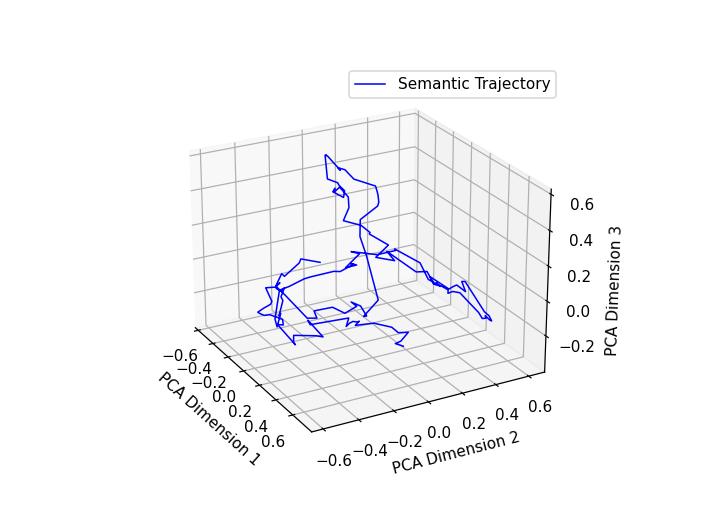

<IPython.core.display.Javascript object>


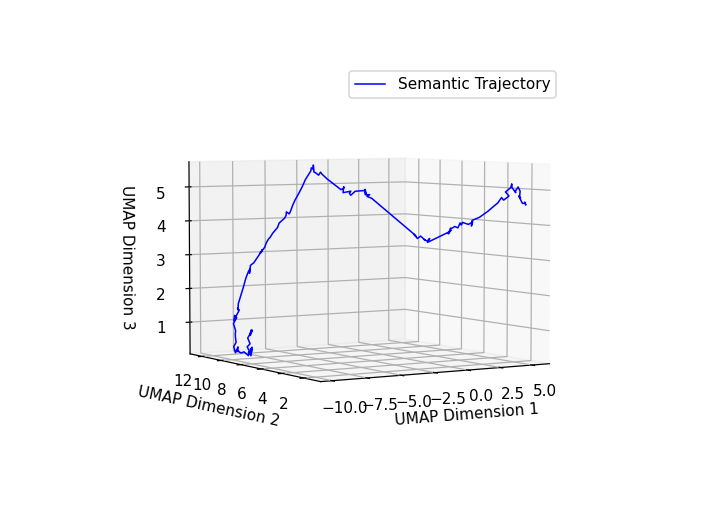

<IPython.core.display.Javascript object>


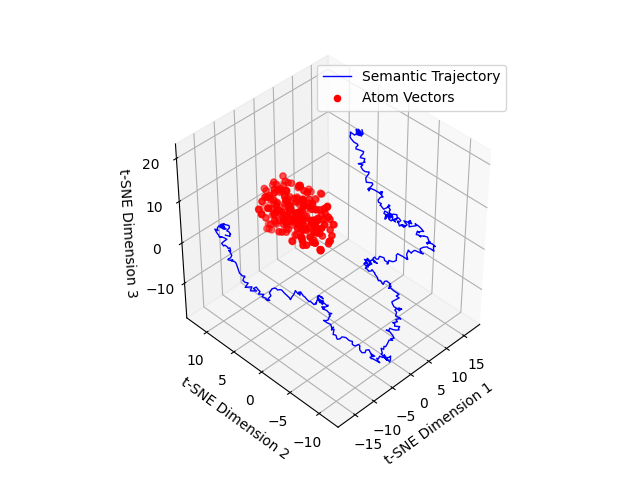

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Assuming you have sentence_embeddings and atom_vectors array
# Combine the embeddings into one array
combined_embeddings = np.vstack((sentence_embeddings, dictionary))

# Use t-SNE for dimensionality reduction to 3D on the combined set
tsne = TSNE(n_components=3, random_state=42)
reduced_combined = tsne.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and atom vectors
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# Create a new plot for 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced sentence embeddings (trajectory)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Plot the reduced atom vectors
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2], color='r', s=20, label='Atom Vectors')

# Set equal scaling for the 3D plot to maintain the aspect ratio
ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Add labels to the axes
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


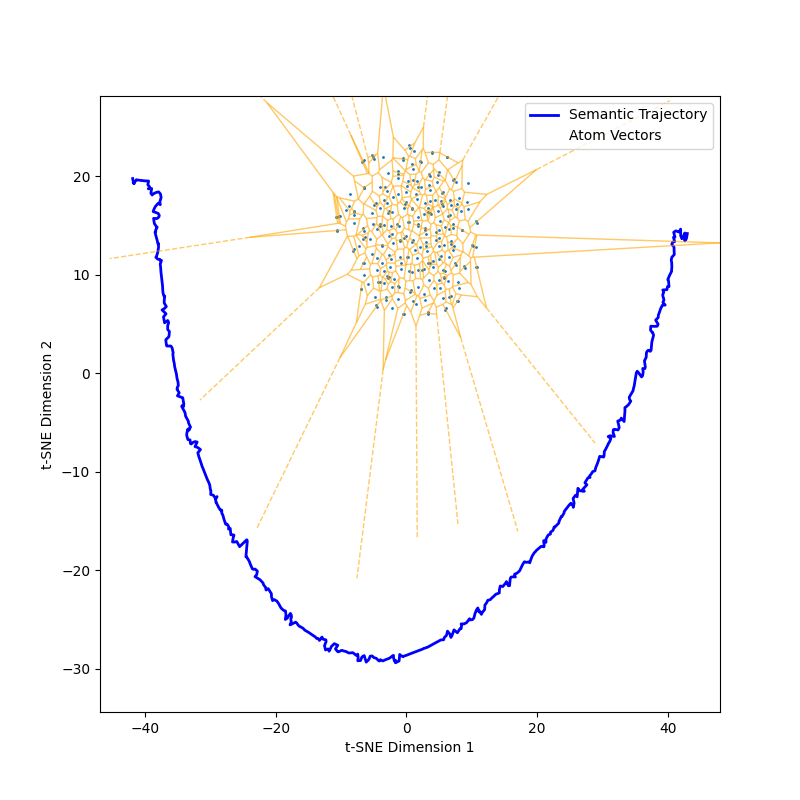

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE

# Assuming you have sentence_embeddings and dictionary (atom_vectors) array
# Combine the embeddings into one array
combined_embeddings = np.vstack((sentence_embeddings, dictionary))

# Use t-SNE for dimensionality reduction to 2D on the combined set
tsne = TSNE(n_components=2, random_state=42)
reduced_combined = tsne.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and dictionary (atom_vectors)
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# Create a Voronoi diagram in 2D using the reduced_vectors (dictionary vectors)
vor = Voronoi(reduced_vectors)

# Create a new plot for 2D projection
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the reduced sentence embeddings as a continuous trajectory (line)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', linewidth=2, label='Semantic Trajectory')

# Alternatively, plot the reduced sentence embeddings as individual points (scatter plot)
# ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', s=30, label='Semantic Trajectory')

# Plot the reduced atom vectors as a scatter plot
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], color='r', s=0, label='Atom Vectors')

# Plot the Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.6, point_size=2)

# Add labels to the axes
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

# Set axis limits based on the data
ax.set_xlim([reduced_combined[:, 0].min() - 5, reduced_combined[:, 0].max() + 5])
ax.set_ylim([reduced_combined[:, 1].min() - 5, reduced_combined[:, 1].max() + 5])

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [213]:
reduced_embeddings

array([[ 39.631947, -21.408522],
       [ 39.75002 , -21.556849],
       [ 39.963158, -21.262154],
       ...,
       [-38.706097, -19.826166],
       [-38.524643, -20.052017],
       [-38.69809 , -20.14541 ]], dtype=float32)

<IPython.core.display.Javascript object>


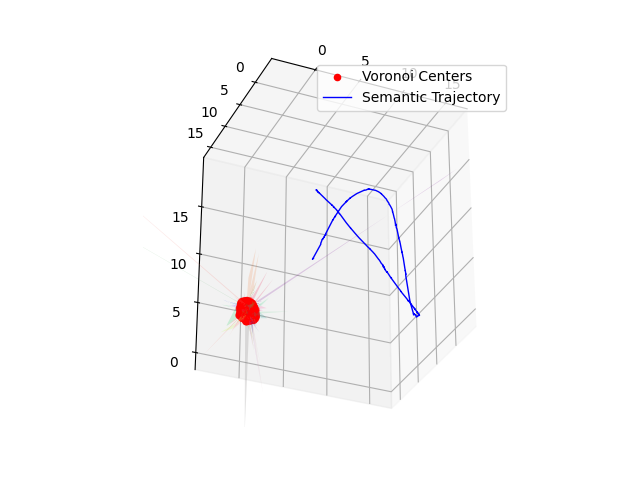

Voronoi indices for UMAP trajectory points: [137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137 137
 137 137 137 137 137 137 137 137 137 137 137 137 137 137 173 173 173 173
 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173 173
 173 173 173 173 173 173 173 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185 185
 185 185 185 185 185 185 185 185 185 185 185 185 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123 123
 123 123 123 123 123 123 123 123 123 123 123 123 210 210 210 210 210 210
 210 210 210 210 210 210 210 210 210 210 210 210 175 175 175 175 175 175
 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175 175
 175 175 175 175 175 196 175 196 196 196 196 196 196 196 196 196 196 196
 196 19

In [36]:
import numpy as np
import umap
from scipy.spatial import Voronoi#, cdist
from scipy.spatial.distance import cdist  # Corrected import
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

combined_embeddings = np.vstack((sentence_embeddings, atom_vectors))

# Use UMAP for dimensionality reduction to 3D on the combined set
umap_reducer = umap.UMAP(n_components=3)
reduced_combined = umap_reducer.fit_transform(combined_embeddings)

# Split the reduced set back into sentence embeddings and atom vectors
reduced_embeddings = reduced_combined[:len(sentence_embeddings)]
reduced_vectors = reduced_combined[len(sentence_embeddings):]

# No normalization to a sphere, we work on the actual UMAP 3D manifold

# Create a Voronoi diagram in 3D using the reduced_vectors
vor = Voronoi(reduced_vectors)

# Calculate Voronoi region for each point in the trajectory (reduced_embeddings)
voronoi_indices = np.argmin(cdist(reduced_embeddings, reduced_vectors), axis=1)

# Create a new plot with the Voronoi diagram on the 3D UMAP manifold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region_idx, region in enumerate(vor.regions):
    if not -1 in region and len(region) > 0:  # Ignore regions with unbounded vertices
        region_points = np.array([vor.vertices[i] for i in region])
        poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
        ax.add_collection3d(poly)

# Plot the original points (Voronoi centers)
ax.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], reduced_vectors[:, 2], color='r', s=20, label='Voronoi Centers')

# Plot the trajectory points (sentence embeddings)
ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], color='blue', linewidth=1, label='Semantic Trajectory')

# Set equal scaling for the 3D plot to maintain the aspect ratio
ax.set_box_aspect([np.ptp(reduced_vectors[:, 0]), np.ptp(reduced_vectors[:, 1]), np.ptp(reduced_vectors[:, 2])])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for UMAP trajectory points:", voronoi_indices)


<IPython.core.display.Javascript object>


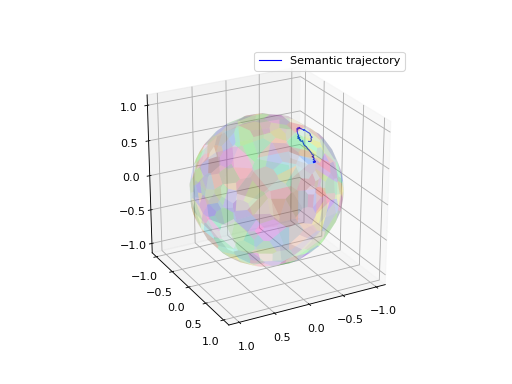

Voronoi indices for t-SNE trajectory points: [247 247 247 247 247 247 247 180 180  21  21 180  21  21  21 175 175 175
 175 175 175 175 175 175 175 175 175 175 175 100 100 100 100 100 100 100
 100 108 108 108 108 108 108 108 108 108 108 108  21  21  21  21  21]


In [180]:
import numpy as np
import umap
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Assuming you have sentence_embeddings and atom_vectors array
# Use UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_components=3)
reduced_embeddings = umap_reducer.fit_transform(sentence_embeddings)
reduced_vectors = umap_reducer.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms_vectors = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
#unit_vectors = reduced_vectors / norms_vectors DOES NOT WWORK WITH UMAP

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Create Voronoi diagram on the unit sphere (using unit_vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Calculate Voronoi region for each point in the trajectory (unit_embeddings)
# This is done by finding the closest unit_vector (Voronoi center) to each trajectory point
voronoi_indices = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Plot the path from sentence_embeddings
ax.plot(unit_embeddings[:, 0], unit_embeddings[:, 1], unit_embeddings[:, 2], color='blue', linewidth=1, label='Semantic trajectory')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for t-SNE trajectory points:", voronoi_indices)


In [144]:
print("Voronoi indices for trajectory points:", voronoi_indices)


Voronoi indices for trajectory points: [134 134 134 134 134 134 134 134 134 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 130 130 130 130 130 130 130 130 130 130 130 130 130
 130 130 130 130 130 130 130 130 219 219 219 219 219 219 219 219 219 219
 204 204   2   2   2   2   2   2   2   2   2   2   2   2 222  28  28  28
  28  94  94  94  94 174 174 174 174 174 174 174 174 174 174 230 215 227
 227 227 227 227 227 227 227 227 227 227 227 227 227  69  69  69  69  69
  69  69  69  69  69  69  69  69 236 236 236 236 226 226 184 184 184 184
 184 184 184 184 184 184 184 184 184 184 184 131 131 131 131 131 131 131
 131 131 131 131 131 131 131 131 124 124  24 209 209 209 209 209 209 209
 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 146
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 136 136 136 136 136 136 136 136 136 136 136
 136 136 136

In [38]:
ind=1
sentences = split_text_into_windows(df_processed['processed_text'].loc[ind], 128)
for idx, a in enumerate(voronoi_indices):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = [tokens[i].replace('ġ', '') for i in top_indices]
    print(a, most_similar_tokens)
    print(sentences[idx])

247 ['mina', 'alam', 'bei', 'sava', 'ari', 'sera', 'vila', 'ze', 'bai', 'maha']
all right so um im moderately bummed that selena just left the room uh i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all
247 ['mina', 'alam', 'bei', 'sava', 'ari', 'sera', 'vila', 'ze', 'bai', 'maha']
right so um im moderately bummed that selena just left the room uh i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fa

21 ['cc', 'mb', 'ms', 'bc', 'pc', 'cm', 'mp', 'md', 'pm', 'hs']
i enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law
21 ['cc', 'mb', 'ms', 'bc', 'pc', 'cm', 'mp', 'md', 'pm', 'hs']
enjoy talking with her uh i would really i think enjoy talking to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect wit

175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
to anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what
175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
anybody right now well maybe anybody thats you know fairly fairly pleasant to um very pleasant uh someone whos really angry right now i proba

175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
fairly pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be
175 ['ford', 'renault', 'toyota', 'volvo', 'nissan', 'honda', 'chevrolet', 'car', 'buick', 'chrysler']
pleasant to um very pleasant uh someone whos really angry right now i probably wouldnt connect with i would you know feel his anger and want to help him uh 

100 ['gertrude', 'mary', 'ernest', 'edith', 'bertha', 'margaret', 'clara', 'george', 'eleanor', 'dorothy']
now i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a
100 ['gertrude', 'mary', 'ernest', 'edith', 'bertha', 'margaret', 'clara', 'george', 'eleanor', 'dorothy']
i probably wouldnt connect with i would you know feel his anger and want to help him uh its weird that i assumed its a him feeling angry but him or h

114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
anger and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a fun anti its the intoxication of it is fun like alcohol without
114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
and want to help him uh its weird that i assumed its a him feeling angry but him or her whoevers feeling angry i would try to calm them dow

114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
its a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really something i can feel myself towards anything right now um well im a little angry hmm not like angry as in like my bodys all tense and im mad but really angry at the dea and uh other law makers um politicians that have made ecstasy illegal if that is indeed what im on right now then uh it really it should be widely available to any consenting adult its really really nice its a fun anti its the intoxication of it is fun like alcohol without the sloppiness without the ego i just uh uh sort of the
114 ['italian', 'madrid', 'barcelona', 'italy', 'french', 'paolo', 'spanish', 'spain', 'francesco', 'bologna']
a him feeling angry but him or her whoevers feeling angry i would try to calm them down but um angers just not really like uh not really s

KeyboardInterrupt: 

In [39]:
print("Voronoi indices for trajectory points using pca:", voronoi_indices_pca)


NameError: name 'voronoi_indices_pca' is not defined

In [40]:
print(voronoi_indices)

[247 247 247 247 247 247 247 247  21  21  21  21  21  21  21  21  21  21
  21  21  21  21  21  21  21 175  21 175 175 175 175 175 175 175 175 175
 175 175 175 175 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114
 114 114 114 114 114 162 162 162 162 162 162 162 162 179 179 179 179 179
 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179 179
 179 193 193 193 153 153 153 153 153 153 153 153 153 153 153 153 153 153
 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 191 191
 191 191 191 191 191 191 152 152  17  17  17  17  17  17  17  17  17  17
  17  17  17  17  17 106 106 106 106 106 106 184 184 226 184 226 226 226
 226 226 226 226 226 226 226 226 236 236 236 236 236 236 236 236 236 236
  89  89  89  89  89  89  89  89 237 237 237 237 237 237 237 237  69  69
  69  69  69  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30
  30 190 190 190 190 190 190 190 190 190 190 190 19

<IPython.core.display.Javascript object>


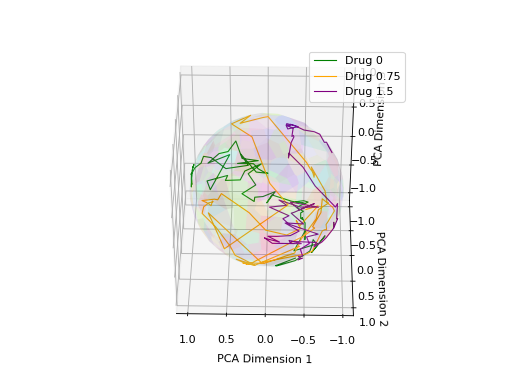

Voronoi indices for PCA sentence_embeddings: [168 113  55 113 155 155 163  35  22 238  31 118 118  42   8  53 107 158
 158  21 108 108 100 100  54 162 162 162 153 191 152 178 106 140 140  80
  80  89  10  68  69  30 241 104  94 167 167   2   2 219 219  20  20]
Voronoi indices for PCA combined embeddings (drugs): [228 228  37 228 243 243 243 243  92 243 243  85  85  85 149 149 149 149
 149 149 149 149 149  15  15 134  15 134 148 134 148 148 116 116 116 120
 120 189 189 116 196 165  66  66 138  98 165 138 143 160 189 160 189 189
 189 180 189 160 189 165  98 202 202 137 249 249 127 127 127 236 236 249
 125 125 125 125  85   2 242  75   3 242 242 204  85  85  63 107 107 107
 107 107 158 158 158 158 108 188 193 153 151 153 162  62 134 246  49 204
 243 243 102 102 102 102 102   9  53 107  63  63  63  85   5 174  51  61
  69  69  68 195  68 195  68  68  69  68 195 245  67  12  12 121 121 121
 144 201  92 244 244 244 244  48  48  48  65  12  12  12  38 234  38  16
 144 234 234 201 234 234 121 

In [188]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Step 1: Apply PCA to sentence_embeddings
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
unit_vectors = reduced_vectors / norms

reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Step 2: Combine embeddings from `vector_dict`
combined_embeddings = []
labels = []  # To track drug labels
for drug, embeddings in vector_dict.items():
    combined_embeddings.extend(embeddings)
    labels.extend([drug] * len(embeddings))  # Label the embeddings by drug

# Convert to numpy array
combined_embeddings = np.vstack(combined_embeddings)

# Step 3: Apply PCA to the combined embeddings from `vector_dict`
reduced_combined = pca.fit_transform(combined_embeddings)

# Step 4: Normalize the embeddings to the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings  # Normalized sentence embeddings

norms_combined = np.linalg.norm(reduced_combined, axis=1).reshape(-1, 1)
unit_combined = reduced_combined / norms_combined  # Normalized combined embeddings (from vector_dict)

# Step 5: Create Voronoi diagram on the unit sphere (assuming unit_vectors are the atom vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Step 6: Calculate Voronoi region for each point in the trajectory
voronoi_indices_pca = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)
voronoi_indices_combined = np.argmin(cdist(unit_combined, unit_vectors), axis=1)

# Step 7: Create the plot with Voronoi diagram and PCA-based trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.1, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the Voronoi vertices
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)
# Plot the paths for each drug condition from `vector_dict` (combined embeddings)
colors = {0: 'green', 0.75: 'orange', 1.5: 'purple'}  # Assign colors to each drug
for drug in vector_dict.keys():
    indices = [i for i, label in enumerate(labels) if label == drug]
    ax.plot(unit_combined[indices, 0], unit_combined[indices, 1], unit_combined[indices, 2], 
            color=colors[drug], linewidth=1, label=f'Drug {drug}')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Add labels to the axes
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')

# Optional: Add a legend to indicate different trajectories
ax.legend()

# Show the plot
plt.show()

# Print the Voronoi indices
print("Voronoi indices for PCA sentence_embeddings:", voronoi_indices_pca)
print("Voronoi indices for PCA combined embeddings (drugs):", voronoi_indices_combined)


<IPython.core.display.Javascript object>


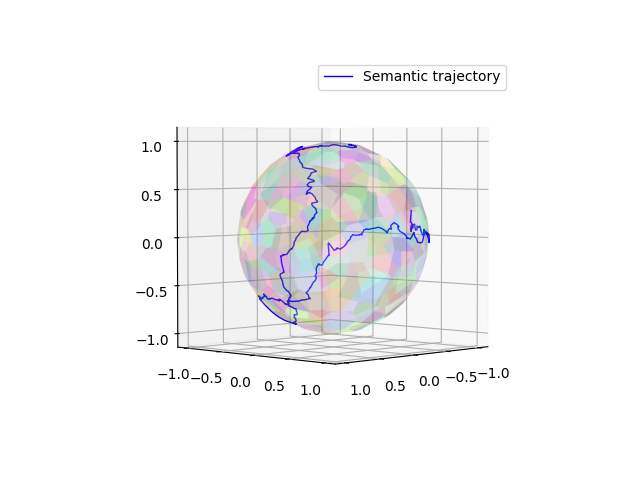

Voronoi indices for t-SNE trajectory points: [ 95  84  84  84  84  19  19  19  19  19  19  19  19  19  19  19  19  19
  19  19  19  19  19  19  19  19  19  84  84  84  84  84  84  84  84  84
  84  84  84  84  84  84  21  21  71  71  21  21  21  21  21  21  21 247
 247 247 247 247 247 148 148 148 148 148  60  60  60  60  60  60  60 159
 159 159 159 159 159 159 159 159 159 159 159 159 166 166 166 166 166 166
 196 196 196 196 196 196 196 196 196 196 196 196 196 196 162 162 162 162
 162 162 162 162 162 162 175 175 175 175 175 175 175 175 175 189 189 189
 189 189 189 189 189 189 189 189 143 143 143 143 143 143 143 143 143 143
 143 143 143 143 143 143 143  43  43  43  43  43  43  43  43  43  43  43
  43  43 185 185 185  43  43  43 190 190 190 190 190 190 190 195 195 195
 195 195 195 236 236 236 236 236 236 236 236 236 236 236 236 236 236 236
 236 236 241 241 241 241 241 241 241 241 241 241 241 241 174 174 174 174
 174 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 1

In [52]:
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial import SphericalVoronoi
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Assuming you have sentence_embeddings and atom_vectors array
# Use t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3)
reduced_embeddings = tsne.fit_transform(sentence_embeddings)
reduced_vectors = tsne.fit_transform(atom_vectors)

# Step 2: Normalize the vectors to map them to a unit sphere
norms_vectors = np.linalg.norm(reduced_vectors, axis=1).reshape(-1, 1)
unit_vectors = reduced_vectors / norms_vectors

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Create Voronoi diagram on the unit sphere (using unit_vectors)
sv = SphericalVoronoi(unit_vectors)
sv.sort_vertices_of_regions()

# Calculate Voronoi region for each point in the trajectory (unit_embeddings)
# This is done by finding the closest unit_vector (Voronoi center) to each trajectory point
voronoi_indices = np.argmin(cdist(unit_embeddings, unit_vectors), axis=1)

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions
for region in sv.regions:
    region_points = np.array([sv.vertices[i] for i in region])
    poly = Poly3DCollection([region_points], alpha=0.2, facecolor=np.random.rand(3))
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Plot the path from sentence_embeddings
ax.plot(unit_embeddings[:, 0], unit_embeddings[:, 1], unit_embeddings[:, 2], color='blue', linewidth=1, label='Semantic trajectory')

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Optional: Add a legend to indicate the path
ax.legend()

# Show the plot
plt.show()

# Print the list of Voronoi indices that the trajectory points fall in
print("Voronoi indices for t-SNE trajectory points:", voronoi_indices)


<IPython.core.display.Javascript object>


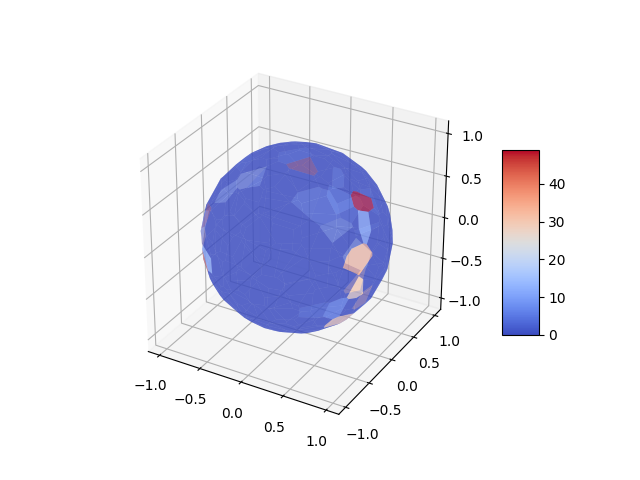

In [218]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import SphericalVoronoi, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

# Assuming you have sentence_embeddings array
# Apply the same PCA transformation to the sentence_embeddings
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Normalize the embeddings to lie on the unit sphere
norms_embeddings = np.linalg.norm(reduced_embeddings, axis=1).reshape(-1, 1)
unit_embeddings = reduced_embeddings / norms_embeddings

# Use KDTree to quickly find nearest Voronoi centroids for each embedding point
voronoi_tree = cKDTree(sv.vertices)
point_counts = np.zeros(len(sv.regions))

# Assign each embedding to the nearest Voronoi vertex
for point in unit_embeddings:
    distance, region_index = voronoi_tree.query(point)
    for i, region in enumerate(sv.regions):
        if region_index in region:
            point_counts[i] += 1
            break

# Normalize point counts for coloring
norm = plt.Normalize(vmin=point_counts.min(), vmax=point_counts.max())
colormap = cm.coolwarm

# Create a new plot with the previous Voronoi diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the Voronoi regions with colors based on point counts
for i, region in enumerate(sv.regions):
    region_points = np.array([sv.vertices[j] for j in region])
    color = colormap(norm(point_counts[i]))  # Color based on the number of points
    poly = Poly3DCollection([region_points], alpha=0.6, facecolor=color)
    ax.add_collection3d(poly)

# Plot the original points from Voronoi
ax.scatter(unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2], color='r', s=0)

# Set equal scaling for a proper sphere visualization
ax.set_box_aspect([1, 1, 1])

# Add a color bar to indicate intensity
mappable = cm.ScalarMappable(cmap=colormap, norm=norm)
mappable.set_array(point_counts)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5)

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


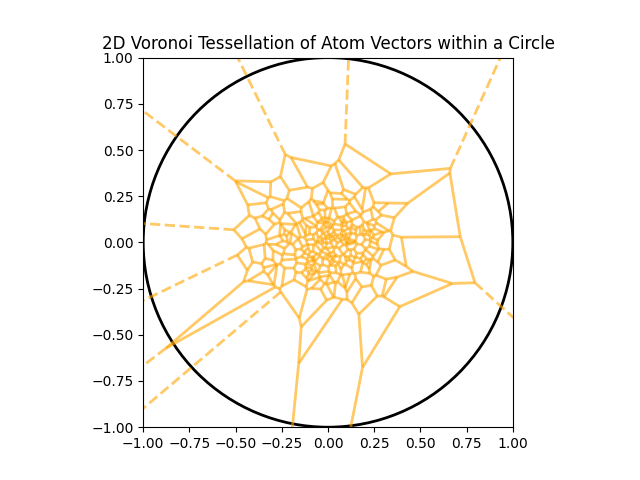

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_voronoi_tessellation_circle(dictionary, radius=1.0):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform PCA to reduce the dimensionality to 2D
    pca = PCA(n_components=2)
    embedding_matrix_2d = pca.fit_transform(atom_vectors)
    
    # Normalize the points to fit within a circle of the given radius
    embedding_matrix_2d = embedding_matrix_2d / np.max(np.linalg.norm(embedding_matrix_2d, axis=1)) * radius

    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=0)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=0)

    # Plot the circle to constrain the tessellation
    circle = plt.Circle((0, 0), radius, color='black', fill=False, lw=2)
    ax.add_artist(circle)

    # Set equal scaling and limits to ensure the circle is properly displayed
    ax.set_aspect('equal')
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    
    plt.title("2D Voronoi Tessellation of Atom Vectors within a Circle")
    plt.show()

# Example usage
# Assume your dictionary is something like: dictionary = {'a': np.array([...]), 'b': np.array([...]), ...}
plot_voronoi_tessellation_circle(dictionary)


<IPython.core.display.Javascript object>


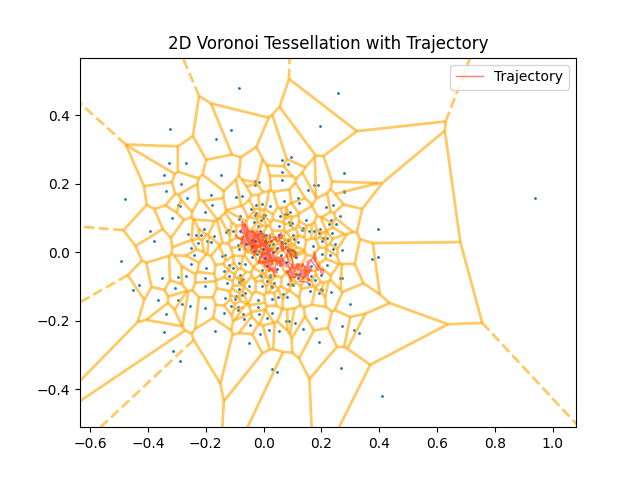

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

def plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform PCA to reduce the dimensionality to 2D for the atom vectors
    pca = PCA(n_components=2)
    embedding_matrix_2d = pca.fit_transform(atom_vectors)
    
    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=0)

    # Perform PCA to reduce sentence_embeddings to 2D
    sentence_embeddings_2d = pca.transform(sentence_embeddings)

    # Plot the 2D trajectory as a continuous path
    ax.plot(sentence_embeddings_2d[:, 0], sentence_embeddings_2d[:, 1], color='red', linewidth=1, alpha=0.5,label='Trajectory')

    # Add a legend
    ax.legend()

    plt.title("2D Voronoi Tessellation with Trajectory")
    plt.show()

# Example usage
# Assume 'dictionary' is your atom vectors and 'sentence_embeddings' is the list of vectors you want to plot as a path
plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings)


<IPython.core.display.Javascript object>


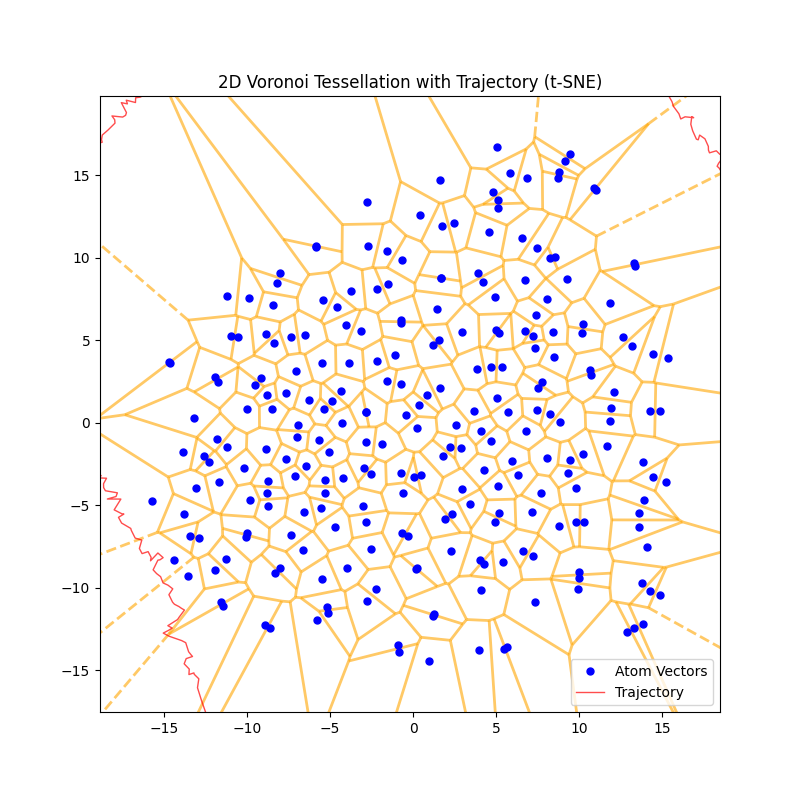

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE

def plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings):
    # Convert atom vectors from the dictionary to a matrix
    atom_vectors = np.array([a.reshape(1, -1) for a in dictionary]).squeeze(1)
    
    # Perform t-SNE to reduce the dimensionality to 2D for the atom vectors
    tsne = TSNE(n_components=2, random_state=42)
    embedding_matrix_2d = tsne.fit_transform(atom_vectors)
    
    # Create Voronoi tessellation based on the 2D projection
    vor = Voronoi(embedding_matrix_2d)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots(figsize=(8, 8))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

    # Plot the original 2D projected points (atom locations)
    ax.plot(embedding_matrix_2d[:, 0], embedding_matrix_2d[:, 1], 'o', color='blue', markersize=5, label='Atom Vectors')

    # Perform t-SNE to reduce sentence_embeddings to 2D
    sentence_embeddings_2d = tsne.fit_transform(sentence_embeddings)

    # Plot the 2D trajectory as a continuous path
    ax.plot(sentence_embeddings_2d[:, 0], sentence_embeddings_2d[:, 1], color='red', linewidth=1, alpha=0.7, label='Trajectory')

    # Add a legend
    ax.legend()

    plt.title("2D Voronoi Tessellation with Trajectory (t-SNE)")
    plt.show()

# Example usage
# Assume 'dictionary' is your atom vectors and 'sentence_embeddings' is the list of vectors you want to plot as a path
plot_voronoi_tessellation_with_trajectory(dictionary, sentence_embeddings)


In [36]:
def get_attention_weighted_null_sentence_embeddings(sentences, model, tokenizer, device='cpu',\
                                                    attention_scaling=1, attention_power=1):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True).to(device)
        token_ids = inputs['input_ids'].squeeze(0)
        # Extract hidden states and attention weights for the last 4 layers
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
            hidden_states = torch.mean(torch.stack(outputs.hidden_states[-4:]), dim=0).squeeze(0)
            attention_scores = torch.mean(torch.stack(outputs.attentions[-4:]), dim=0).squeeze(0)
            # Average attention scores across heads
            attention_weights = attention_scores.mean(dim=0)  # (seq_len, seq_len)
        # Compute attention-based weights for each token
        token_weights = attention_weights.sum(dim=0)  # Sum attention over all tokens to get per-token weight
        # Optional adjustments to the attention weights
        if attention_power != 1.0:
            token_weights = token_weights ** attention_power
        token_weights = token_weights / token_weights.sum()  # Normalize
        token_weights = token_weights.unsqueeze(-1)  # (seq_len, 1)
        sentence_embedding = (hidden_states * 1).sum(dim=0).cpu().numpy()
        embeddings.append(sentence_embedding)
    return np.array(embeddings)
def apply_attention_weighting_null(sentences, model, tokenizer, device='cpu',weighting=1, sub_pc=True):
    sentence_embeddings = get_attention_weighted_null_sentence_embeddings(sentences, model, tokenizer, device)
 # Subtract projection onto principal component
    return sentence_embeddings
def process_texts_null(df, model, tokenizer, atom_vectors, window='sentences',\
                  method='AW', windowsize=128):
    sentence_embeddings_column = []
    most_similar_atoms_column = []
    # Wrapping the loop with tqdm for progress tracking
    for text in tqdm(df['processed_text'], desc="Processing texts"):
        # Step 1: Split text into sentences
        if window=='window':
            sentences=split_text_into_windows(text, windowsize)
        elif window=='sentences':
            sentences = split_text_into_sentences(text)
        # Step 2: Get sentence embeddings using BERT
        sentence_embeddings = apply_attention_weighting_null(sentences, model,\
                                                        tokenizer,device,sub_pc=False)

        # Step 4: Append results
        most_similar_atoms = get_most_similar_atoms(sentence_embeddings, dictionary)
        sentence_embeddings_column.append(sentence_embeddings)
        most_similar_atoms_column.append(most_similar_atoms)
    # Add results to DataFrame
    df['sentence_embeddings'] = sentence_embeddings_column
    df['most_similar_atoms'] = most_similar_atoms_column

    return df

In [37]:
df_processed_null = process_texts_null(df.iloc[1:2], model, tokenizer, dictionary,window='window', method='AW')


Processing texts: 100%|██████████████████████████| 1/1 [03:56<00:00, 236.15s/it]
/tmp/ipykernel_213554/3310139949.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentence_embeddings'] = sentence_embeddings_column
/tmp/ipykernel_213554/3310139949.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['most_similar_atoms'] = most_similar_atoms_column


In [39]:
ind=1
sentences = split_text_into_windows(df_processed_null['processed_text'].loc[ind], 128)
for idx, a in enumerate(df_processed_null['most_similar_atoms'].loc[ind]):
    atom_vector = dictionary[a].reshape(1, -1)
    sim_scores = cosine_similarity(atom_vector, embedding_matrix)[0]

    
    # Get the indices of the top_n most similar tokens
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]  # Sort by similarity score, descending
    
    # Get the corresponding token strings and clean them by removing the 'ġ'
    most_similar_tokens = [tokens[i].replace('ġ', '') for i in top_indices]
    print(a, most_similar_tokens)
    print(sentences[idx])

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um i mean the whole day saturday with universal and the mechanical bull and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i mean the whole day saturday with universal and the mechanical bull and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
being with my co workers all day it was really fun yeah um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all th

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lets see they came and picked me up from my house which was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole rea

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
nice at like noon and then we went to universal yeah not long its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
its like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like minutes its in studio city so unlike disney and whatever thats all the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all t

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
the way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
way out in anaheim i used to work at universal like the whole reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
reason i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i went is because when i worked at nbc which was my job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
job i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
i just left like two months ago they gave all their employees free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
free passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
passes for a year so i was i mean i used to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched wit

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
to have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
have a minute commute to work and now its but i got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas go

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
got that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
that minutes again when we went back to the park so yeah we got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fou

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
got there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
there and then on the way i was showing them videos of this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
this guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
guy i matched with on hinge who was on americas got talent because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fo

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
because hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
hes in a group called human fountains and theyre these men who spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
spit water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
water out of their mouths in time to music like in choreographed dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
dances like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like a fountain and then they like spit water like into each others mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really w

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
mouths yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
yeah its super crazy and really funny and so then we watched those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
those videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
videos in the car and they were like okay no he had something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was real

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
something else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
else to do and i only really wanted him to come if he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
he was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was going to perform as a human fountain otherwise i didnt need like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a random to be at the party yeah yeah um so that was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day it

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
really fun funny at universal and then you know we went on a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lot of rides like long lines we waited like an hour for everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there we

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
everything so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
so we actually went on like four rides the whole day its insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
insane but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
but you know we were like drinking in line exactly yeah right so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah l

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
so sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
sometimes it was like there were times that it was boring during the day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty mu

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
day and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and like just like a lot of waiting but it was never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
never bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
bad yeah it was good yeah like either neutral or positive yeah definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven drop

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
definitely um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
um so that was fun and that pretty much took the whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested wh

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
whole day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
day and then at like i dont know eight oclock ish maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really ta

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
maybe diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
diego one of my co workers whod driven dropped us all off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
off back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
back at my house and my friends like laid down pretty much and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like a

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
and rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
rested while i this isnt really something we havent really talked about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was runni

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
about here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
here but it is a major coping mechanism of mine i smoke a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i w

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
a lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
lot of weed from a vape pen i got home and like as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to g

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
as im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
im getting ready for this party yeah yeah so she was running around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
around like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
like trying to set things up and i could tell that she was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night p

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
was anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
anxious so i was like i wasnt anxious but i was like leaving my friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
friends to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
to go help exactlyyeah which was fine it wasnt the end of the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright s

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
the world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
world um but then i did get sad at one point during the night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my 

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
night probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah yeah i tend to dwell on yeah yeah i tried to do something like
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
probably because i was like a little drunk and also because this is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal

26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
is completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like a little weird to me up and down yeah i helped with her party im still gonna pay for it im not gonna i cant go back in time and change my birthday but i was kind of annoyed yeah yeah i tend to dwell on yeah yeah i tried to do something like that ah this week and ended up feeling like easily the worst i
26 ['in', 'with', 'on', 'for', 'to', 'of', 'from', 'and', 'that', 'by']
completely true and i am kind of annoyed about it which is that alright so happy that jess wants to throw a party and that i can invite my friends and im not the person whos going to make a big deal out of it im just going to pay you on venmo and its fine however it is like

In [ ]:
df_processed.to_csv('./atomed_data.csv')